In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/mit_bih/

/content/drive/MyDrive/mit_bih


In [ ]:
!ls -l

total 4
drwx------ 2 root root 4096 Nov  6 06:00 mit-bih-arrhythmia-database-1.0.0


In [ ]:
!pip install wfdb

In [ ]:
!ls -l

total 4
drwx------ 2 root root 4096 Nov  6 06:00 mit-bih-arrhythmia-database-1.0.0


In [ ]:
import wfdb

In [ ]:
record_name = 'mit-bih-arrhythmia-database-1.0.0/100'

In [ ]:
record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')
print(record.sig_name)
print(record.fs )
print( record.sig_len)
print(record.p_signal.shape)
print(record.p_signal[:5])
print(annotation.symbol[:10])
print(annotation.sample[:10])

['MLII', 'V5']
360
650000
(650000, 2)
[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']
[  18   77  370  662  946 1231 1515 1809 2044 2402]


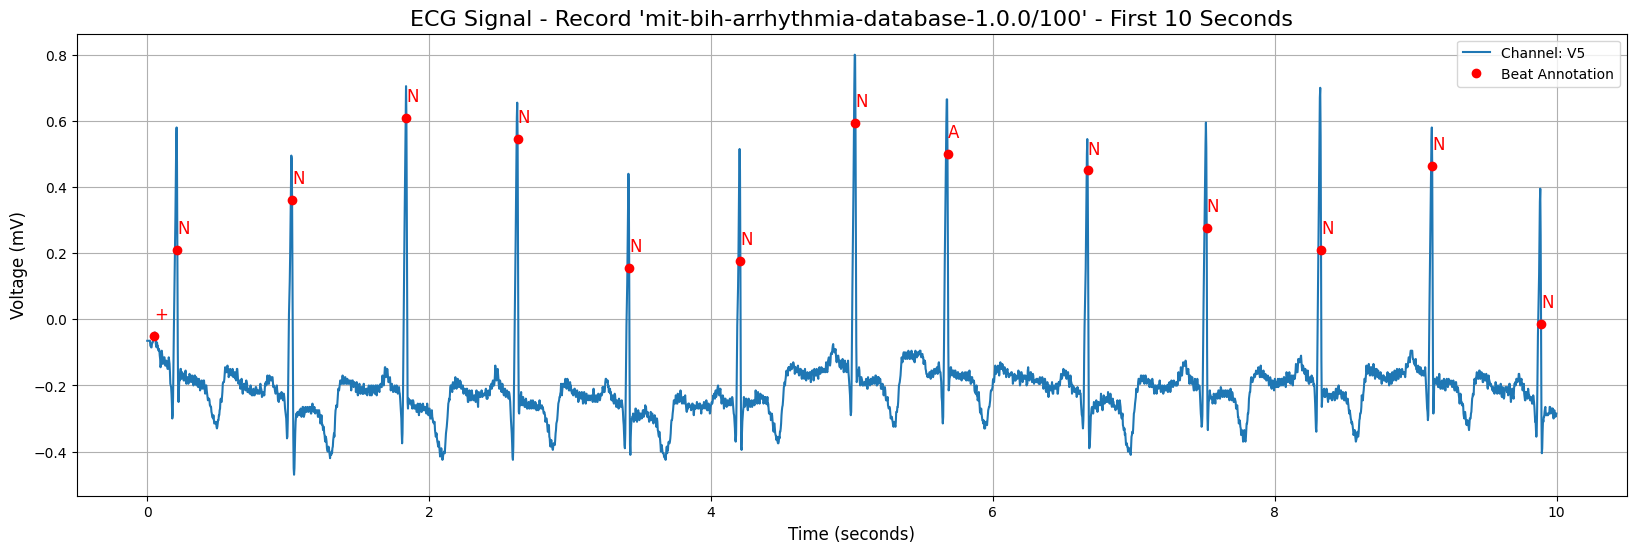

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

seconds_to_plot = 10
channel_to_plot = 1

fs = record.fs

num_samples = seconds_to_plot * fs

signal = record.p_signal[:num_samples, channel_to_plot]

time_axis = np.arange(num_samples) / fs

ann_indices_in_range = np.where(annotation.sample < num_samples)[0]
ann_samples_in_range = annotation.sample[ann_indices_in_range]
ann_symbols_in_range = np.array(annotation.symbol)[ann_indices_in_range]

ann_y_values = signal[ann_samples_in_range]

plt.figure(figsize=(20, 6))

plt.plot(time_axis, signal, label=f'Channel: {record.sig_name[channel_to_plot]}')

plt.plot(ann_samples_in_range / fs, ann_y_values, 'ro', label='Beat Annotation')

for i, symbol in enumerate(ann_symbols_in_range):
    plt.text(ann_samples_in_range[i] / fs, ann_y_values[i] + 0.05, symbol, fontsize=12, color='red')

plt.title(f"ECG Signal - Record '{record_name}' - First {seconds_to_plot} Seconds", fontsize=16)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Voltage (mV)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

ecg_signals=record.p_signal

type(ecg_signals)

numpy.ndarray

In [ ]:
print(ecg_signals[5:])

[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]


In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler

raw_signals = record.p_signal
print(type(raw_signals))
print(f"Original shape (samples, channels): {raw_signals.shape}")

<class 'numpy.ndarray'>
Original shape (samples, channels): (650000, 2)


In [ ]:
raw_signals = record.p_signal

mlii_raw = raw_signals[:, 0]
v5_raw = raw_signals[:, 1]

summed_signal_raw = mlii_raw + v5_raw

print( mlii_raw.shape)
print(summed_signal_raw.shape)

print(f"  Original Mean: {np.mean(summed_signal_raw)}")
print(f"  Original Std Dev: {np.std(summed_signal_raw)}")

summed_signal_reshaped = summed_signal_raw.reshape(-1, 1)

scaler_summed = StandardScaler()
scaled_summed_signal = scaler_summed.fit_transform(summed_signal_reshaped)

print(f"\n--- 'AFTER' Scaling Summed Signal ---")
print(f"  Scaled Mean: {np.mean(scaled_summed_signal)}")
print(f"  Scaled Std Dev: {np.std(scaled_summed_signal)}")

print(scaled_summed_signal[:5])

(650000,)
(650000,)
  Original Mean: -0.4973334076923078
  Original Std Dev: 0.3062989011772449

--- 'AFTER' Scaling Summed Signal ---
  Scaled Mean: 4.561465735045764e-16
  Scaled Std Dev: 0.9999999999999998
[[0.93808174]
 [0.93808174]
 [0.93808174]
 [0.93808174]
 [0.93808174]]


In [ ]:
import wfdb.processing

fs = record.fs

xqrs = wfdb.processing.XQRS(sig=summed_signal_raw, fs=fs)
xqrs.detect()

detected_peaks = xqrs.qrs_inds
print("\n--- XQRS Detection (Experiment) ---")
print(annotation.sample[:10])

print(detected_peaks[:10])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.

--- XQRS Detection (Experiment) ---
[  18   77  370  662  946 1231 1515 1809 2044 2402]
[  75  369  661  945 1230 1513 1808 2043 2401 2704]


In [ ]:
import wfdb.processing

fs = record.fs

xqrs = wfdb.processing.XQRS(sig=mlii_raw, fs=fs)
xqrs.detect()

detected_peaks = xqrs.qrs_inds
print("\n--- XQRS Detection (Experiment) ---")
print(annotation.sample[:10])

print(detected_peaks[:10])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.

--- XQRS Detection (Experiment) ---
[  18   77  370  662  946 1231 1515 1809 2044 2402]
[  76  370  662  946 1231 1515 1809 2044 2402 2705]


In [ ]:
import numpy as np
import wfdb
import wfdb.processing


print("Running XQRS peak detection...")
fs = record.fs
xqrs = wfdb.processing.XQRS(sig=summed_signal_raw, fs=fs)
xqrs.detect()

detected_peaks = xqrs.qrs_inds
print(f"Found {len(detected_peaks)} peaks using XQRS.")


final_signal = scaled_summed_signal.flatten()

true_peaks = annotation.sample
true_labels = annotation.symbol

valid_beat_labels = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

# --- Configuration ---
window_size = 180
win_half_left = window_size // 2  # 90
win_half_right = window_size // 2 # 90
tolerance = int(0.1 * fs) # 100ms tolerance (e.g., 36 samples)

heartbeats = []
labels = []

print(window_size)

for xqrs_peak in detected_peaks:

    start = xqrs_peak - win_half_left
    end = xqrs_peak + win_half_right

    if start < 0 or end >= len(final_signal):
        continue

    distances = np.abs(true_peaks - xqrs_peak)
    closest_true_index = np.argmin(distances)
    if distances[closest_true_index] <= tolerance:
        label = true_labels[closest_true_index]

        if label in valid_beat_labels:
            segment = final_signal[start:end]
            heartbeats.append(segment)
            labels.append(label)

# --- Final Conversion ---
X_data = np.array(heartbeats)
y_data = np.array(labels)

print("\n--- Preprocessing Complete ---")
print(f"Shape of X_data (beats, features): {X_data.shape}")
print(f"Shape of y_data (labels,): {y_data.shape}")
print(f"Total valid beats found and segmented: {len(y_data)}")

print(y_data[:5])

Running XQRS peak detection...
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Found 2273 peaks using XQRS.
180

--- Preprocessing Complete ---
Shape of X_data (beats, features): (2271, 180)
Shape of y_data (labels,): (2271,)
Total valid beats found and segmented: 2271
['N' 'N' 'N' 'N' 'N']


In [ ]:
import numpy as np
import wfdb
import wfdb.processing
from sklearn.preprocessing import StandardScaler
import os
from glob import glob
from tqdm import tqdm # For a helpful progress bar


data_dir = 'mit-bih-arrhythmia-database-1.0.0'

header_files = glob(os.path.join(data_dir, '*.hea'))
record_names = [os.path.basename(f).replace('.hea', '') for f in header_files]
record_names = [r for r in record_names if r.isdigit()]
record_names.sort()

print(f"Found {len(record_names)} records. Starting processing...")

all_X_data = []
all_y_data = []

# --- 3. Define Parameters ---
valid_beat_labels = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']
window_size = 180
win_half_left = window_size // 2
win_half_right = window_size // 2

for record_name in tqdm(record_names):
    record_path = os.path.join(data_dir, record_name)

    try:
        # --- A: Load Data ---
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        fs = record.fs

        # --- B: Create Summed Signal (RAW) ---
        mlii_raw = record.p_signal[:, 0]
        v5_raw = record.p_signal[:, 1]
        summed_signal_raw = mlii_raw + v5_raw

        # --- C: Scale the Summed Signal ---
        # We re-fit the scaler for each record.
        summed_signal_reshaped = summed_signal_raw.reshape(-1, 1)
        scaler_summed = StandardScaler()
        scaled_summed_signal = scaler_summed.fit_transform(summed_signal_reshaped)
        final_signal = scaled_summed_signal.flatten() # 1D scaled signal

        # --- D: Run XQRS on RAW Signal ---
        xqrs = wfdb.processing.XQRS(sig=summed_signal_raw, fs=fs)
        # Pass verbose=False to stop it from printing "Learning..." 2273 times
        xqrs.detect(verbose=False)
        detected_peaks = xqrs.qrs_inds

        true_peaks = annotation.sample
        true_labels = annotation.symbol
        tolerance = int(0.1 * fs) # 100ms tolerance

        heartbeats = []
        labels = []

        for xqrs_peak in detected_peaks:
            start = xqrs_peak - win_half_left
            end = xqrs_peak + win_half_right

            if start < 0 or end >= len(final_signal):
                continue # Skip beats too close to the edge

            # Find the closest "true" label
            distances = np.abs(true_peaks - xqrs_peak)
            closest_true_index = np.argmin(distances)

            if distances[closest_true_index] <= tolerance:
                label = true_labels[closest_true_index]
                if label in valid_beat_labels:
                    segment = final_signal[start:end]
                    heartbeats.append(segment)
                    labels.append(label)

        # --- F: Append this file's data to global lists ---
        if len(heartbeats) > 0:
            all_X_data.append(np.array(heartbeats))
            all_y_data.append(np.array(labels))

    except Exception as e:
        print(f"\nError processing record {record_name}: {e}")

print("\n Processing Complete")

X_final_dataset = np.concatenate(all_X_data, axis=0)
y_final_dataset = np.concatenate(all_y_data, axis=0)

print(f"Final X_data shape  {X_final_dataset.shape}")
print(f"Final y_data shape {y_final_dataset.shape}")

# --- You can now save these or use them directly ---
np.save('/content/drive/MyDrive/mit_bih/X_data_summed.npy', X_final_dataset)
np.save('/content/drive/MyDrive/mit_bih/y_data_summed.npy', y_final_dataset)

Found 48 records. Starting processing...


100%|██████████| 48/48 [03:46<00:00,  4.73s/it]



 Processing Complete
Final X_data shape  (108008, 180)
Final y_data shape (108008,)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# N: Normal ('N', 'L', 'R', 'e', 'j')
# S: Supraventricular ('A', 'a', 'J', 'S')
# V: Ventricular ('V', 'E')
# F: Fusion ('F')
# Q: Unknown ('Q', '?', '/', 'f')

label_mapping = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    'Q': 'Q', '?': 'Q', '/': 'Q', 'f': 'Q',
    'B': 'N'

}

y_labels = y_final_dataset.copy()
y_categories = pd.Series(y_labels).map(label_mapping)


print("'Table 1' (Class Counts")
initial_counts = y_categories.value_counts()
print(initial_counts)
print(f"\nTotal beats (before dropping): {len(y_categories)}")
print(f"Beats not mapped (NaN): {y_categories.isna().sum()}")


# We create a filter 'mask' to select only the data we want
mask = y_categories.isin(['N', 'S', 'V', 'F'])

# Applying the mask to BOTH X and y
X_filtered = X_final_dataset[mask]
y_filtered = y_categories[mask]

print(f"Total heartbeats for training: {len(y_filtered)}")



print("\nSplitting ...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_filtered,
    y_filtered,
    test_size=0.25,
    stratify=y_filtered,
    random_state=42
)

print("Splitting Train/Val ")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.20,
    stratify=y_train_val,
    random_state=42
)

print("\n Final Data Shapes ---")
print(f" {X_train.shape}, {y_train.shape}")
print(f" {X_val.shape}, {y_val.shape}")
print(f"   {X_test.shape}, {y_test.shape}")


print(y_train.value_counts())


classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Create a dictionary for easy use (e.g., in Keras)
class_weight_dict = dict(zip(classes, weights))

print(f"Classes: {classes}")
print(f"Weights: {weights}")
print(class_weight_dict)

'Table 1' (Class Counts
N    90283
Q     8024
V     6222
S     2701
F      778
Name: count, dtype: int64

Total beats (before dropping): 108008
Beats not mapped (NaN): 0
Total heartbeats for training: 99984

Splitting ...
Splitting Train/Val 

 Final Data Shapes ---
 (59990, 180), (59990,)
 (14998, 180), (14998,)
   (24996, 180), (24996,)
N    54169
V     3734
S     1621
F      466
Name: count, dtype: int64
Classes: ['F' 'N' 'S' 'V']
Weights: [32.18347639  0.276865    9.25200494  4.01647027]
{'F': np.float64(32.183476394849784), 'N': np.float64(0.2768649965847625), 'S': np.float64(9.25200493522517), 'V': np.float64(4.016470273165506)}


In [ ]:
import numpy as np
import os

save_dir = '/content/drive/MyDrive/mit_bih/'

os.makedirs(save_dir, exist_ok=True)

print(f"Saving files to: {save_dir}\n")

try:
    # Save Training data
    np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
    print("Saved X_train.npy and y_train.npy")

    # Save Validation data
    np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
    print("Saved X_val.npy and y_val.npy")

    # Save Testing data
    np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
    print("Saved X_test.npy and y_test.npy")

    print("\n saved successfully.")

except Exception as e:
    print(f"error  {e}")

Saving files to: /content/drive/MyDrive/mit_bih/

Saved X_train.npy and y_train.npy
Saved X_val.npy and y_val.npy
Saved X_test.npy and y_test.npy

 saved successfully.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dropout, BatchNormalization,
    Flatten, Dense
)

from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


label_encoder = LabelEncoder()

y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

print(f"Original labels: {y_train[:5]}")
print(f"Encoded labels: {y_train_int[:5]}")
print(f"Classes: {label_encoder.classes_}")



class_weight_dict_int = {}
for i, cls in enumerate(label_encoder.classes_):
    class_weight_dict_int[i] = class_weight_dict[cls]

print(class_weight_dict_int)



X_train_cnn = np.expand_dims(X_train, axis=-1)
X_val_cnn = np.expand_dims(X_val, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

print(f"Old X_train  {X_train.shape}")
print(f"New X_train  {X_train_cnn.shape}")

Original labels: 49479    N
13775    N
12518    N
68140    N
76487    N
dtype: object
Encoded labels: [1 1 1 1 1]
Classes: ['F' 'N' 'S' 'V']
{0: np.float64(32.183476394849784), 1: np.float64(0.2768649965847625), 2: np.float64(9.25200493522517), 3: np.float64(4.016470273165506)}
Old X_train  (59990, 180)
New X_train  (59990, 180, 1)


In [ ]:
import joblib
np.save(os.path.join(save_dir, 'class_weights.npy'), class_weight_dict_int)
print("Saved class_weights.npy")

    # 2. Save the Label Encoder
joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.joblib'))
print("Saved label_encoder.joblib")

Saved class_weights.npy
Saved label_encoder.joblib


In [ ]:
filters = 64
kernel = 3
blocks = 2
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2]) # (180, 1)

model = Sequential()

for i in range(blocks):
    print(f"Adding Block {i+1}")

    #  Conv1D (filter, (kernel,), 'relu') ---
    if i == 0:
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel,
            activation='relu',
            input_shape=input_shape
        ))
    else:
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel,
            activation='relu'
        ))

    # --- Line 4: Conv1D (filter, (kernel,), 'relu') ---
    model.add(Conv1D(
        filters=filters,
        kernel_size=kernel,
        activation='relu'
    ))

    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(4, activation='softmax'))

model.summary()

Adding Block 1
Adding Block 2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 176, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 88, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 86, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 84, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,376,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,416,644 (5.40 MB)

 Trainable params: 1,416,388 (5.40 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
print("\n--- Compiling Model (Phase 1) ---")

optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='sparse_categorical_crossentropy', # For integer labels
    optimizer=optimizer,
    metrics=['accuracy']
)

print("Model compiled successfully.")

print("\n--- Training Model (Phase 2) ---")

epochs = 50

history = model.fit(
    X_train_cnn,                  # input_data
    y_train_int,
    batch_size=512,               # batch_size
    epochs=epochs,                # epochs

    validation_data=(X_val_cnn, y_val_int),

    class_weight=class_weight_dict_int # cls_weight
)

print("Model training complete.")

save_dir = '/content/drive/MyDrive/mit_bih/'
model_name = 'my_summed_signal_model.keras'
model_save_path = os.path.join(save_dir, model_name)

print(f"\nSaving model to: {model_save_path}")
try:
    model.save(model_save_path)
    print(" Model saved successfully.")
except Exception as e:
    print(f"\n{e}")
# --------------------------------

print("\n--- Evaluating Model ")

test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_int, verbose=0)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

predictions_prob = model.predict(X_test_cnn)

predictions_class = np.argmax(predictions_prob, axis=1)

print("\n--- Classification Report (Test Data) ---")
print(classification_report(
    y_test_int,
    predictions_class,
    target_names=label_encoder.classes_ # Map back to 'N', 'S', 'V', 'F'
))


--- Compiling Model (Phase 1) ---
Model compiled successfully.

--- Training Model (Phase 2) ---
Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 645ms/step - accuracy: 0.5418 - loss: 1.2107 - val_accuracy: 0.8909 - val_loss: 0.7116
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 644ms/step - accuracy: 0.7589 - loss: 0.4851 - val_accuracy: 0.6127 - val_loss: 0.8437
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 672ms/step - accuracy: 0.8153 - loss: 0.3753 - val_accuracy: 0.5393 - val_loss: 1.0151
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 615ms/step - accuracy: 0.8537 - loss: 0.2963 - val_accuracy: 0.8246 - val_loss: 0.4872
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 610ms/step - accuracy: 0.8866 - loss: 0.2337 - val_accuracy: 0.8716 - val_loss: 0.3721
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 616ms/step - accuracy: 0.8422 - loss: 0.2784 - val_accuracy: 0.9197 - val_loss: 0.2504
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 632ms/step - accuracy: 0.8974 - loss: 0.2174 - val_accuracy: 0.9042 - va

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.0 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy.signal as sp
import os

def add_baseline_wander(sig, fs=360):
    t = np.arange(len(sig)) / fs
    drift = 0.1 * np.sin(2*np.pi*0.3*t) + 0.2 * np.sin(2*np.pi*0.1*t)
    return sig + drift

def add_powerline(sig, fs=360):
    t = np.arange(len(sig)) / fs
    noise = 0.05 * np.sin(2*np.pi*50*t)
    return sig + noise

def add_gaussian(sig):
    return sig + np.random.normal(0, 0.05, sig.shape)

def add_emg(sig):
    emg = np.random.normal(0, 0.1, sig.shape)
    emg = sp.lfilter([1], [1, -0.99], emg)
    return sig + emg

data_dir = '/content/drive/MyDrive/mit_bih/'
CLEAN_DATA_PATH = os.path.join(data_dir, 'X_train.npy')
NOISY_DATA_PATH = os.path.join(data_dir, 'X_train_augmented_all_noise.npy')

X_train_clean = np.load(CLEAN_DATA_PATH)

X_train_noisy = []
for beat in X_train_clean:
    noisy_beat = beat.copy()
    noisy_beat = add_baseline_wander(noisy_beat)
    noisy_beat = add_powerline(noisy_beat)
    noisy_beat = add_gaussian(noisy_beat)
    noisy_beat = add_emg(noisy_beat)
    X_train_noisy.append(noisy_beat)

X_train_noisy = np.array(X_train_noisy)

X_train_noisy_cnn = np.expand_dims(X_train_noisy, axis=-1)

np.save(NOISY_DATA_PATH, X_train_noisy_cnn)

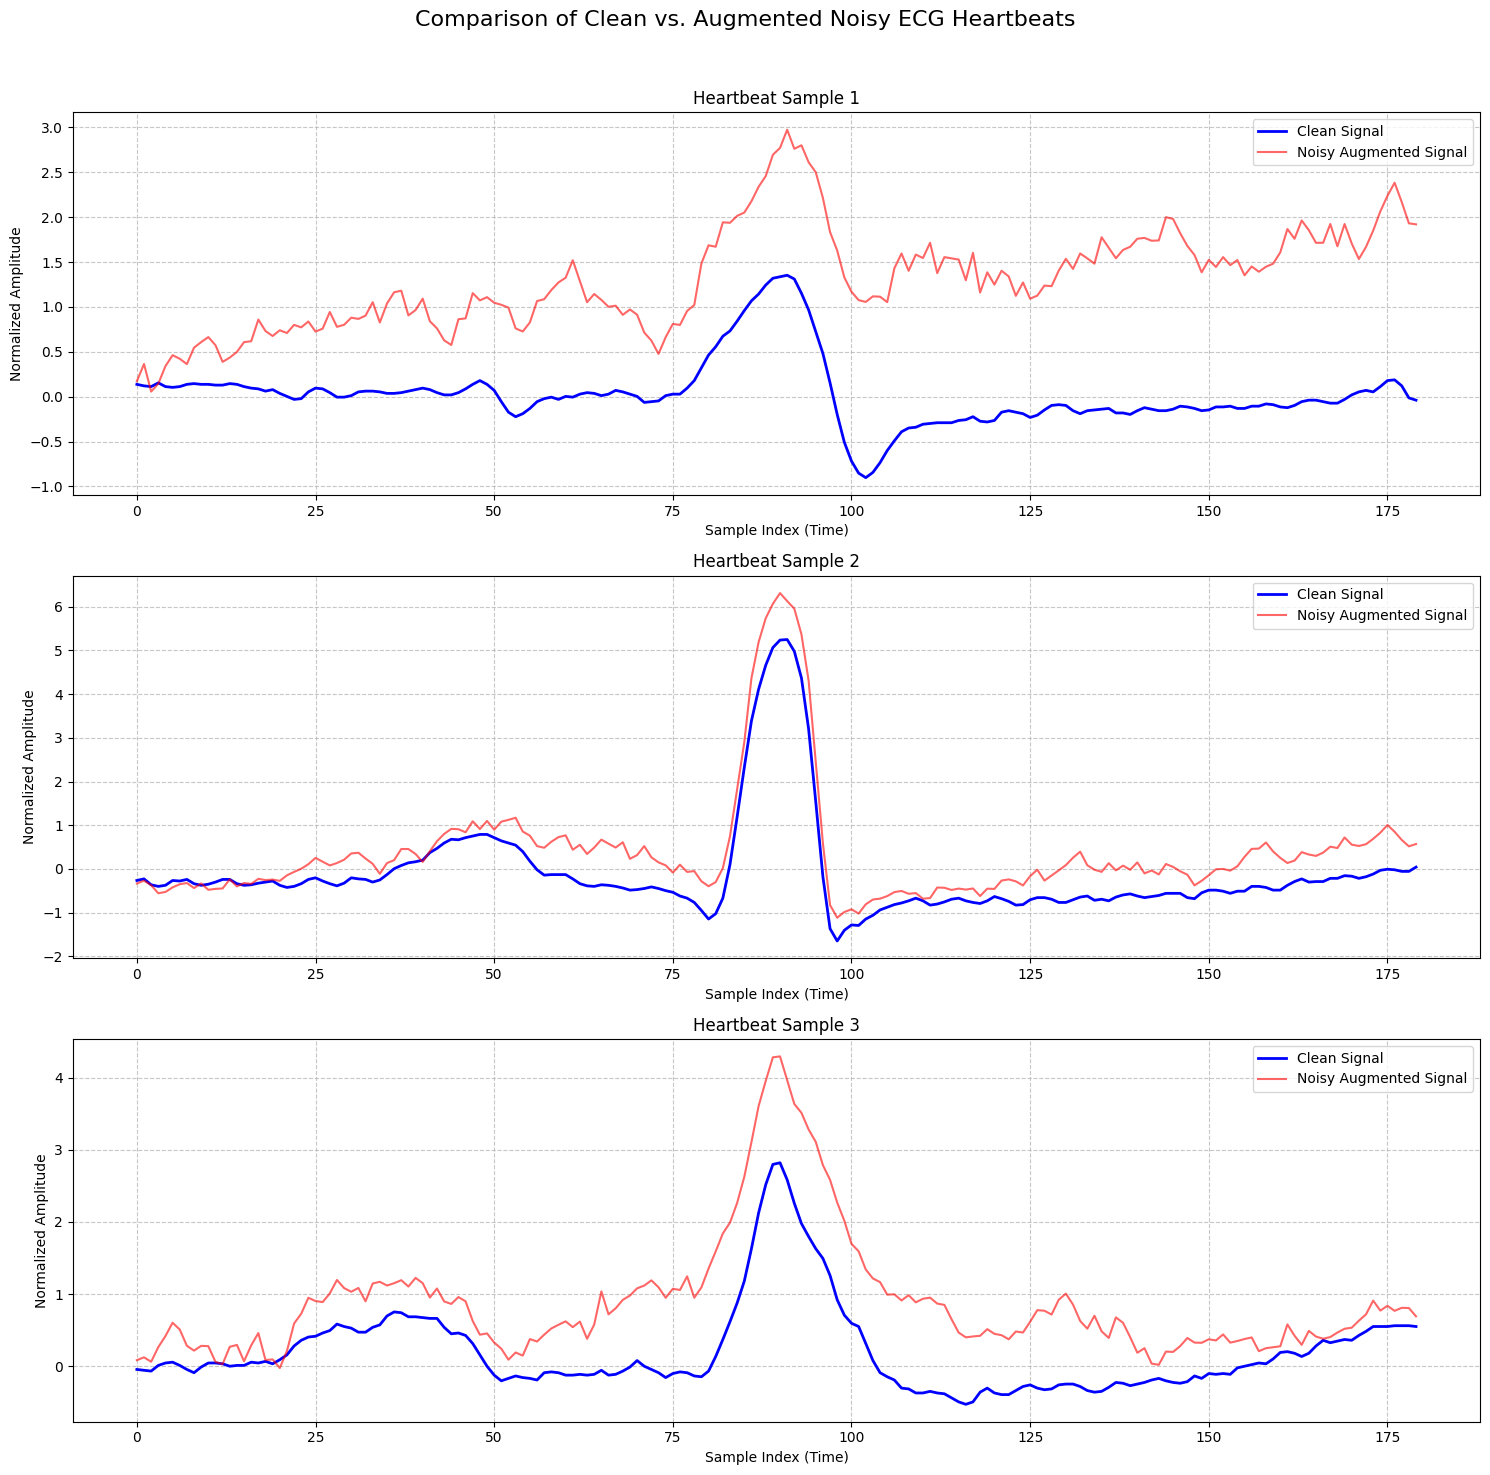

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure these files are in the same folder as this script ---
CLEAN_DATA_PATH = 'X_train.npy'
NOISY_DATA_PATH = 'X_train_augmented_all_noise.npy'

# Load the data
X_clean = np.load(CLEAN_DATA_PATH)
X_noisy_cnn = np.load(NOISY_DATA_PATH)

# Prepare noisy data for plotting (remove the final single dimension)
X_noisy = np.squeeze(X_noisy_cnn)

# Select a few samples for visualization
num_samples = 3
indices = np.arange(num_samples)

fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5 * num_samples))
fig.suptitle('Comparison of Clean vs. Augmented Noisy ECG Heartbeats', fontsize=16)

time_vector = np.arange(X_clean.shape[1])

for i, idx in enumerate(indices):
    ax = axes[i]

    # Plot Clean Signal
    ax.plot(time_vector, X_clean[idx, :], label='Clean Signal', color='blue', linewidth=2)

    # Plot Noisy Signal (Overlaid)
    ax.plot(time_vector, X_noisy[idx, :], label='Noisy Augmented Signal', color='red', alpha=0.6, linewidth=1.5)

    ax.set_title(f"Heartbeat Sample {idx+1}")
    ax.set_xlabel("Sample Index (Time)")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import joblib
import os

# --- 1. Define File Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
MODEL_PATH = os.path.join(data_dir, 'my_summed_signal_model.keras')
X_NOISY_PATH = os.path.join(data_dir, 'X_train_augmented_all_noise.npy')
Y_TRAIN_PATH = os.path.join(data_dir, 'y_train.npy')
WEIGHTS_PATH = os.path.join(data_dir, 'class_weights.npy')
ENCODER_PATH = os.path.join(data_dir, 'label_encoder.joblib')

# --- 2. Load Data and Auxiliary Files ---
# Load the newly augmented noisy data
X_train_noisy_cnn = np.load(X_NOISY_PATH)
y_train = np.load(Y_TRAIN_PATH, allow_pickle=True)

# Load helper files
class_weight_dict_int = np.load(WEIGHTS_PATH, allow_pickle=True).item()
label_encoder = joblib.load(ENCODER_PATH)

# --- 3. Encode Labels for Training ---
y_train_int = label_encoder.transform(y_train)

# --- 4. Load Pre-trained Model ---
model = load_model(MODEL_PATH)

# --- 5. Fine-Tuning Configuration ---
# Set a very low learning rate for fine-tuning
new_learning_rate = 1e-5
model.trainable = True

optimizer_ft = Adam(learning_rate=new_learning_rate)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer_ft,
    metrics=['accuracy']
)

# --- 6. Fine-Tune the Model ---
# Train for a small number of epochs (e.g., 10) on the noisy data
print("Starting fine-tuning on noisy data...")
history_ft = model.fit(
    X_train_noisy_cnn,
    y_train_int,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
    class_weight=class_weight_dict_int,
    verbose=1
)

# --- 7. Save the Fine-Tuned Model ---
model_ft_name = 'my_fine_tuned_noisy_model.keras'
model_ft_save_path = os.path.join(data_dir, model_ft_name)
model.save(model_ft_save_path)

print(f"\nFine-tuning complete. New model saved to: {model_ft_save_path}")

Starting fine-tuning on noisy data...
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 616ms/step - accuracy: 0.8747 - loss: 1.2764 - val_accuracy: 0.9032 - val_loss: 0.3835
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 618ms/step - accuracy: 0.8592 - loss: 1.0904 - val_accuracy: 0.8906 - val_loss: 0.4336
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 627ms/step - accuracy: 0.8503 - loss: 0.9259 - val_accuracy: 0.8803 - val_loss: 0.4667
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 608ms/step - accuracy: 0.8399 - loss: 0.8036 - val_accuracy: 0.8726 - val_loss: 0.4870
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.8338 - loss: 0.8041 - val_accuracy: 0.8658 - val_loss: 0.5084
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 602ms/step - accuracy: 0.8262 - loss: 0.7244 - val_accuracy: 0.8645 - val_loss: 0.5162
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 611ms/step - accuracy: 0.8198 - loss: 0.6453 - val_accuracy: 0.8618 - val_loss: 0.5194
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 63s 5

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
import os

# --- Define File Paths ---
# NOTE: Please ensure all these files exist in this exact path or adjust the directory.
data_dir = '/content/drive/MyDrive/mit_bih/'
MODEL_PATH = os.path.join(data_dir, 'my_fine_tuned_noisy_model.keras')
X_TEST_PATH = os.path.join(data_dir, 'X_test.npy')
Y_TEST_PATH = os.path.join(data_dir, 'y_test.npy')
ENCODER_PATH = os.path.join(data_dir, 'label_encoder.joblib')

# Load the fine-tuned model and test data
try:
    model_ft = load_model(MODEL_PATH)
    X_test = np.load(X_TEST_PATH)
    y_test = np.load(Y_TEST_PATH, allow_pickle=True)
    label_encoder = joblib.load(ENCODER_PATH)
except FileNotFoundError as e:
    print(f"Error loading required files: {e}. Please ensure all files are in the specified path.")
    # Exit if files aren't found
    raise

# Prepare Test Data
X_test_cnn = np.expand_dims(X_test, axis=-1)
y_test_int = label_encoder.transform(y_test)
target_names = label_encoder.classes_

# Evaluate Fine-Tuned Model
print("Evaluating fine-tuned model on the clean test set...")
predictions_prob = model_ft.predict(X_test_cnn)
predictions_class = np.argmax(predictions_prob, axis=1)

print("\n--- Classification Report (Fine-Tuned Model) ---")
print(classification_report(
    y_test_int,
    predictions_class,
    target_names=target_names
))

test_loss, test_accuracy = model_ft.evaluate(X_test_cnn, y_test_int, verbose=0)
print(f"\nOverall Test Accuracy (Fine-Tuned): {test_accuracy * 100:.2f}%")

Evaluating fine-tuned model on the clean test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step

--- Classification Report (Fine-Tuned Model) ---
              precision    recall  f1-score   support

           F       0.11      0.90      0.20       195
           N       1.00      0.90      0.95     22571
           S       0.50      0.91      0.64       675
           V       0.88      0.96      0.92      1555

    accuracy                           0.91     24996
   macro avg       0.62      0.92      0.68     24996
weighted avg       0.97      0.91      0.93     24996


Overall Test Accuracy (Fine-Tuned): 90.78%


In [ ]:
import numpy as np
import scipy.signal as sp
import os

# --- Noise Functions (Copied from Augmentation Step) ---
def add_baseline_wander(sig, fs=360):
    t = np.arange(len(sig)) / fs
    drift = 0.1 * np.sin(2*np.pi*0.3*t) + 0.2 * np.sin(2*np.pi*0.1*t)
    return sig + drift

def add_powerline(sig, fs=360):
    t = np.arange(len(sig)) / fs
    noise = 0.05 * np.sin(2*np.pi*50*t)
    return sig + noise

def add_gaussian(sig):
    return sig + np.random.normal(0, 0.05, sig.shape)

def add_emg(sig):
    emg = np.random.normal(0, 0.1, sig.shape)
    emg = sp.lfilter([1], [1, -0.99], emg)
    return sig + emg

# --- File Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
X_TEST_PATH = os.path.join(data_dir, 'X_test.npy')
X_TEST_NOISY_PATH = os.path.join(data_dir, 'X_test_noisy.npy')

# Load clean test data
X_test_clean = np.load(X_TEST_PATH)

# Apply all noise types to create the noisy test set
X_test_noisy = []
for beat in X_test_clean:
    noisy_beat = beat.copy()
    noisy_beat = add_baseline_wander(noisy_beat)
    noisy_beat = add_powerline(noisy_beat)
    noisy_beat = add_gaussian(noisy_beat)
    noisy_beat = add_emg(noisy_beat)
    X_test_noisy.append(noisy_beat)

X_test_noisy = np.array(X_test_noisy)

# Reshape for CNN input (samples, 180, 1)
X_test_noisy_cnn = np.expand_dims(X_test_noisy, axis=-1)

# Save the new noisy test data
np.save(X_TEST_NOISY_PATH, X_test_noisy_cnn)

print(f"Noisy test set generated and saved to: {X_TEST_NOISY_PATH}")

Noisy test set generated and saved to: /content/drive/MyDrive/mit_bih/X_test_noisy.npy


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
import os

# --- File Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
# Load BOTH models:
MODEL_ORIGINAL_PATH = os.path.join(data_dir, 'my_summed_signal_model.keras') # Original clean model
MODEL_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_noisy_model.keras')  # Fine-tuned model

# Load data/helpers:
X_TEST_NOISY_PATH = os.path.join(data_dir, 'X_test_noisy.npy')
Y_TEST_PATH = os.path.join(data_dir, 'y_test.npy')
ENCODER_PATH = os.path.join(data_dir, 'label_encoder.joblib')

# Load models, data, and helpers
model_original = load_model(MODEL_ORIGINAL_PATH)
model_ft = load_model(MODEL_FT_PATH)
X_test_noisy_cnn = np.load(X_TEST_NOISY_PATH)
y_test = np.load(Y_TEST_PATH, allow_pickle=True)
label_encoder = joblib.load(ENCODER_PATH)

y_test_int = label_encoder.transform(y_test)
target_names = label_encoder.classes_

def evaluate_model(model, X_data, y_true_int, name):
    """Predicts, evaluates, and prints report for a given model."""
    print(f"\n===== EVALUATING: {name} =====")
    predictions_prob = model.predict(X_data, verbose=0)
    predictions_class = np.argmax(predictions_prob, axis=1)

    loss, accuracy = model.evaluate(X_data, y_true_int, verbose=0)

    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    print("\n--- Classification Report ---")
    print(classification_report(
        y_true_int,
        predictions_class,
        target_names=target_names
    ))
    return accuracy

# Run the comparative evaluation
print("Starting comparative evaluation on the NOISY TEST SET...")
accuracy_original = evaluate_model(model_original, X_test_noisy_cnn, y_test_int, "Original Model (Clean Trained)")
accuracy_ft = evaluate_model(model_ft, X_test_noisy_cnn, y_test_int, "Fine-Tuned Model (Noisy Augmented)")

print("\n--- Summary ---")
if accuracy_ft > accuracy_original:
    print("✅ SUCCESS! Fine-tuning improved robustness against noise.")
else:
    print("❌ FAILURE. Fine-tuning did not improve robustness. The noise was too extreme.")

Starting comparative evaluation on the NOISY TEST SET...

===== EVALUATING: Original Model (Clean Trained) =====
Overall Accuracy: 90.77%

--- Classification Report ---
              precision    recall  f1-score   support

           F       0.27      0.19      0.22       195
           N       0.97      0.92      0.95     22571
           S       0.37      0.68      0.48       675
           V       0.60      0.85      0.70      1555

    accuracy                           0.91     24996
   macro avg       0.55      0.66      0.59     24996
weighted avg       0.93      0.91      0.92     24996


===== EVALUATING: Fine-Tuned Model (Noisy Augmented) =====
Overall Accuracy: 84.63%

--- Classification Report ---
              precision    recall  f1-score   support

           F       0.09      0.64      0.16       195
           N       0.99      0.85      0.91     22571
           S       0.26      0.79      0.40       675
           V       0.62      0.91      0.74      1555

    accu

In [ ]:
import numpy as np
import scipy.signal as sp
import os

# --- Reduced Noise Parameters (Approx. 75% reduction from previous attempt) ---
# This significantly lowers the intensity to prevent over-degradation
GAUSSIAN_STD_NEW = 0.0125
PLI_AMPLITUDE_NEW = 0.0125
BW_AMPLITUDE_1_NEW = 0.025
BW_AMPLITUDE_2_NEW = 0.050

def add_baseline_wander_reduced(sig, fs=360):
    t = np.arange(len(sig)) / fs
    drift = BW_AMPLITUDE_1_NEW * np.sin(2*np.pi*0.3*t) + BW_AMPLITUDE_2_NEW * np.sin(2*np.pi*0.1*t)
    return sig + drift

def add_powerline_reduced(sig, fs=360):
    t = np.arange(len(sig)) / fs
    noise = PLI_AMPLITUDE_NEW * np.sin(2*np.pi*50*t)
    return sig + noise

def add_gaussian_reduced(sig):
    return sig + np.random.normal(0, GAUSSIAN_STD_NEW, sig.shape)

def add_emg_reduced(sig):
    # EMG amplitude also reduced
    emg = np.random.normal(0, GAUSSIAN_STD_NEW * 2, sig.shape)
    emg = sp.lfilter([1], [1, -0.99], emg)
    return sig + emg

# --- File Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
CLEAN_DATA_PATH = os.path.join(data_dir, 'X_train.npy')
Y_TRAIN_PATH = os.path.join(data_dir, 'y_train.npy')
X_TRAIN_MIXED_PATH = os.path.join(data_dir, 'X_train_mixed_reduced_noise.npy')
Y_TRAIN_MIXED_PATH = os.path.join(data_dir, 'y_train_mixed_reduced_noise.npy')

# Load clean training data and labels
X_train_clean = np.load(CLEAN_DATA_PATH)
y_train_clean = np.load(Y_TRAIN_PATH, allow_pickle=True)

# Generate a second, equal-sized noisy dataset (using reduced noise)
X_train_reduced_noisy = []
for beat in X_train_clean:
    # Sequentially apply all four reduced noise types
    noisy_beat = beat.copy()
    noisy_beat = add_baseline_wander_reduced(noisy_beat)
    noisy_beat = add_powerline_reduced(noisy_beat)
    noisy_beat = add_gaussian_reduced(noisy_beat)
    noisy_beat = add_emg_reduced(noisy_beat)
    X_train_reduced_noisy.append(noisy_beat)

X_train_reduced_noisy = np.array(X_train_reduced_noisy)

# --- Combine Data (50% Clean, 50% Noisy) ---
X_train_mixed = np.concatenate([X_train_clean, X_train_reduced_noisy], axis=0)
y_train_mixed = np.concatenate([y_train_clean, y_train_clean], axis=0)

# Reshape for CNN input: (samples, 180, 1)
X_train_mixed_cnn = np.expand_dims(X_train_mixed, axis=-1)

# Save the new mixed training data and labels
np.save(X_TRAIN_MIXED_PATH, X_train_mixed_cnn)
np.save(Y_TRAIN_MIXED_PATH, y_train_mixed)

print(f"Mixed (50% Clean / 50% Low-Noise) dataset created and saved. New total size: {X_train_mixed_cnn.shape}")

Mixed (50% Clean / 50% Low-Noise) dataset created and saved. New total size: (119980, 180, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib
import os

# --- File Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
MODEL_PATH = os.path.join(data_dir, 'my_summed_signal_model.keras')
X_MIXED_PATH = os.path.join(data_dir, 'X_train_mixed_reduced_noise.npy')
Y_MIXED_PATH = os.path.join(data_dir, 'y_train_mixed_reduced_noise.npy')
ENCODER_PATH = os.path.join(data_dir, 'label_encoder.joblib')

# --- Load Data and Auxiliary Files ---
X_train_mixed_cnn = np.load(X_MIXED_PATH)
y_train_mixed = np.load(Y_MIXED_PATH, allow_pickle=True)
label_encoder = joblib.load(ENCODER_PATH)

# --- Prepare Labels and Weights ---
y_train_mixed_int = label_encoder.transform(y_train_mixed)
classes = np.unique(y_train_mixed)

# Re-calculate class weights based on the new, doubled dataset
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_mixed
)
class_weight_dict_int = dict(zip(label_encoder.transform(classes), weights))


# --- Load Model and Configure Fine-Tuning ---
model = load_model(MODEL_PATH)
new_learning_rate = 1e-5
model.trainable = True

optimizer_ft = Adam(learning_rate=new_learning_rate)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer_ft,
    metrics=['accuracy']
)

# --- Fine-Tune the Model (v2) ---
print("Starting Fine-Tuning V2 on Mixed (50% Clean / 50% Low-Noise) Data...")
model.fit(
    X_train_mixed_cnn,
    y_train_mixed_int,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
    class_weight=class_weight_dict_int,
    verbose=1
)

# --- Save the Fine-Tuned Model v2 ---
model_ft_v2_name = 'my_fine_tuned_v2_mixed_low_noise_model.keras'
model_ft_v2_save_path = os.path.join(data_dir, model_ft_v2_name)
model.save(model_ft_v2_save_path)

print(f"\nFine-Tuning V2 complete. New model saved to: {model_ft_v2_save_path}")

Starting Fine-Tuning V2 on Mixed (50% Clean / 50% Low-Noise) Data...
Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 138s 609ms/step - accuracy: 0.9866 - loss: 0.0368 - val_accuracy: 0.9911 - val_loss: 0.0310
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 128s 609ms/step - accuracy: 0.9861 - loss: 0.0334 - val_accuracy: 0.9906 - val_loss: 0.0317
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 140s 598ms/step - accuracy: 0.9861 - loss: 0.0288 - val_accuracy: 0.9905 - val_loss: 0.0314
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 128s 605ms/step - accuracy: 0.9863 - loss: 0.0275 - val_accuracy: 0.9907 - val_loss: 0.0313
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 137s 580ms/step - accuracy: 0.9871 - loss: 0.0233 - val_accuracy: 0.9908 - val_loss: 0.0303
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 144s 590ms/step - accuracy: 0.9863 - loss: 0.0233 - val_accuracy: 0.9910 - val_loss: 0.0289
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 128s 608ms/step - accuracy: 0.9873 - loss: 0.0253 - val_accuracy: 0.9913 - val_loss: 0.0280
Epoch 8

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import joblib
import os

# --- Define File Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
# Model 1: Trained on PURELY CLEAN data
MODEL_ORIGINAL_PATH = os.path.join(data_dir, 'my_summed_signal_model.keras')
# Model 2: Trained on CLEAN then Fine-Tuned on HEAVY NOISE
MODEL_HEAVY_NOISY_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_noisy_model.keras')
# Model 3: Trained on PURELY HEAVY NOISE
MODEL_PURE_NOISE_PATH = os.path.join(data_dir, 'model_B_noisy.keras')
# Model 4: Fine-Tuned on 50/50 Mixed, Low-Noise Data (The new model)
MODEL_MIXED_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_v2_mixed_low_noise_model.keras')

# Data/Helpers
X_TEST_NOISY_PATH = os.path.join(data_dir, 'X_test_noisy.npy')
Y_TEST_PATH = os.path.join(data_dir, 'y_test.npy')
ENCODER_PATH = os.path.join(data_dir, 'label_encoder.joblib')

# Load data and helpers only once
X_test_noisy_cnn = np.load(X_TEST_NOISY_PATH)
y_test = np.load(Y_TEST_PATH, allow_pickle=True)
label_encoder = joblib.load(ENCODER_PATH)

y_test_int = label_encoder.transform(y_test)
target_names = label_encoder.classes_

# List of models to evaluate
models_to_evaluate = [
    {"name": "1. Original (Clean Trained)", "path": MODEL_ORIGINAL_PATH},
    {"name": "2. Fine-Tuned (Clean + Heavy Noise FT)", "path": MODEL_HEAVY_NOISY_FT_PATH},
    {"name": "3. Purely Noisy Trained", "path": MODEL_PURE_NOISE_PATH},
    {"name": "4. Fine-Tuned (50/50 Mixed, V2)", "path": MODEL_MIXED_FT_PATH},
]

def evaluate_model(model_path, X_data, y_true_int, name, target_names):
    """Loads a model, predicts, evaluates, and prints report."""
    try:
        model = load_model(model_path)
    except Exception as e:
        print(f"Skipping {name}: Error loading model from {model_path}. {e}")
        return None, None, None

    print(f"\n===== EVALUATING: {name} =====")
    predictions_prob = model.predict(X_data, verbose=0)
    predictions_class = np.argmax(predictions_prob, axis=1)

    loss, accuracy = model.evaluate(X_data, y_true_int, verbose=0)

    report = classification_report(
        y_true_int,
        predictions_class,
        target_names=target_names,
        output_dict=True
    )

    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    print("\n--- Classification Report (F1-Scores) ---")

    f1_scores = {cls: report[cls]['f1-score'] for cls in target_names}
    for cls, f1 in f1_scores.items():
        print(f"  {cls}: {f1:.4f}")

    return accuracy, report['macro avg']['f1-score'], f1_scores


# --- Run Evaluation on NOISY TEST SET ---
results = []
print("Starting UNIFIED Comparative Evaluation on the NOISY TEST SET...")

for model_info in models_to_evaluate:
    accuracy, macro_f1, f1_scores = evaluate_model(
        model_info["path"],
        X_test_noisy_cnn,
        y_test_int,
        model_info["name"],
        target_names
    )
    if accuracy is not None:
        results.append({
            "Model": model_info["name"],
            "Accuracy": accuracy,
            "Macro F1": macro_f1,
            "F1 Scores": f1_scores
        })

# --- Final Comparison Table ---
print("\n" + "="*50)
print("       FINAL ROBUSTNESS COMPARISON (NOISY TEST SET)")
print("="*50)

header = ["Model", "Accuracy", "Macro F1", "N F1", "S F1", "V F1", "F F1"]
print(f"{header[0]:<30}{header[1]:<10}{header[2]:<10}{header[3]:<8}{header[4]:<8}{header[5]:<8}{header[6]:<8}")
print("-" * 80)

for res in results:
    f1s = res["F1 Scores"]
    print(f"{res['Model']:<30}{res['Accuracy'] * 100:<10.2f}{res['Macro F1']:<10.4f}{f1s['N']:<8.4f}{f1s['S']:<8.4f}{f1s['V']:<8.4f}{f1s['F']:<8.4f}")

Starting UNIFIED Comparative Evaluation on the NOISY TEST SET...

===== EVALUATING: 1. Original (Clean Trained) =====
Overall Accuracy: 90.77%

--- Classification Report (F1-Scores) ---
  F: 0.2222
  N: 0.9490
  S: 0.4828
  V: 0.7018

===== EVALUATING: 2. Fine-Tuned (Clean + Heavy Noise FT) =====
Overall Accuracy: 84.63%

--- Classification Report (F1-Scores) ---
  F: 0.1607
  N: 0.9108
  S: 0.3953
  V: 0.7361

===== EVALUATING: 3. Purely Noisy Trained =====
Overall Accuracy: 91.57%

--- Classification Report (F1-Scores) ---
  F: 0.2636
  N: 0.9544
  S: 0.4212
  V: 0.7065

===== EVALUATING: 4. Fine-Tuned (50/50 Mixed, V2) =====
Overall Accuracy: 91.07%

--- Classification Report (F1-Scores) ---
  F: 0.2722
  N: 0.9506
  S: 0.4617
  V: 0.7242

       FINAL ROBUSTNESS COMPARISON (NOISY TEST SET)
Model                         Accuracy  Macro F1  N F1    S F1    V F1    F F1    
--------------------------------------------------------------------------------
1. Original (Clean Trained)   9

In [ ]:
!cd /content/drive/MyDrive/mit_bih/ && wget -r -N -c -np https://physionet.org/files/nstdb/1.0.0/

--2025-11-16 03:28:02--  https://physionet.org/files/nstdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/nstdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]   7.79K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-11-16 03:28:02 (812 MB/s) - ‘physionet.org/files/nstdb/1.0.0/index.html’ saved [7982]

Loading robots.txt; please ignore errors.
--2025-11-16 03:28:02--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2025-11-16 03:28:02 (3.25 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2025-11-16 03:28:02-

In [ ]:
# Original path placeholder
NSTDB_DIR = os.path.join(data_dir, 'nstdb/')

# Change to the actual downloaded path
# This assumes the wget command completed successfully:
NSTDB_DIR = os.path.join(data_dir, 'physionet.org/files/nstdb/1.0.0/')

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import numpy as np
import wfdb
import os
import random

# --- Configuration ---
data_dir = '/content/drive/MyDrive/mit_bih/'
CLEAN_TEST_PATH = os.path.join(data_dir, 'X_test.npy')
FS = 360  # MIT-BIH Sample Frequency
SEGMENT_LEN = 180
TARGET_SNR_DB = 10.0

# The path where wget placed the noise files
NSTDB_DIR = os.path.join(data_dir, 'physionet.org/files/nstdb/1.0.0/')
NOISE_RECORD_NAME = 'em' # Electrode Motion noise
NOISE_TEST_PATH = os.path.join(data_dir, 'X_test_nstdb_10db_noise.npy')

def generate_real_noise_test_set():
    # Load clean test data
    X_clean = np.load(CLEAN_TEST_PATH)

    # Load NSTDB Noise Record (Electrode Motion)
    noise_record_path = os.path.join(NSTDB_DIR, NOISE_RECORD_NAME)
    noise_record = wfdb.rdrecord(noise_record_path)
    noise_signal = noise_record.p_signal[:, 0]

    X_noisy_nstdb = []

    # Calculate desired ratio
    desired_ratio = 10**(TARGET_SNR_DB / 20)

    for clean_beat in X_clean:
        clean_energy = np.linalg.norm(clean_beat)

        # Randomly select a 180-sample segment of noise
        start_index = random.randint(0, len(noise_signal) - SEGMENT_LEN)
        noise_segment = noise_signal[start_index : start_index + SEGMENT_LEN]
        noise_energy = np.linalg.norm(noise_segment)

        # Calculate the scaling factor (alpha) to achieve the target SNR
        if noise_energy == 0:
            alpha = 0
        else:
            alpha = (clean_energy / noise_energy) / desired_ratio

        # Mix and add to list
        scaled_noise_segment = alpha * noise_segment
        noisy_beat = clean_beat + scaled_noise_segment

        X_noisy_nstdb.append(noisy_beat)

    X_noisy_nstdb = np.array(X_noisy_nstdb)
    X_noisy_nstdb_cnn = np.expand_dims(X_noisy_nstdb, axis=-1)

    np.save(NOISE_TEST_PATH, X_noisy_nstdb_cnn)
    return X_noisy_nstdb_cnn

# Execute and get the new test data
X_test_nstdb_cnn = generate_real_noise_test_set()
print(f"Generated {len(X_test_nstdb_cnn)} real-noise test beats at 10 dB SNR.")

Generated 24996 real-noise test beats at 10 dB SNR.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import joblib
import os

# --- Model Paths ---
data_dir = '/content/drive/MyDrive/mit_bih/'
MODEL_ORIGINAL_PATH = os.path.join(data_dir, 'my_summed_signal_model.keras')
MODEL_HEAVY_NOISY_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_noisy_model.keras')
MODEL_PURE_NOISE_PATH = os.path.join(data_dir, 'model_B_noisy.keras')
MODEL_MIXED_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_v2_mixed_low_noise_model.keras')

# --- Data/Helpers ---
X_TEST_NSTDB_PATH = os.path.join(data_dir, 'X_test_nstdb_10db_noise.npy')
Y_TEST_PATH = os.path.join(data_dir, 'y_test.npy')
ENCODER_PATH = os.path.join(data_dir, 'label_encoder.joblib')

# Load the real-noise test data generated in the previous step
X_test_nstdb_cnn = np.load(X_TEST_NSTDB_PATH)
y_test = np.load(Y_TEST_PATH, allow_pickle=True)
label_encoder = joblib.load(ENCODER_PATH)

y_test_int = label_encoder.transform(y_test)
target_names = label_encoder.classes_

# List of models to evaluate
models_to_evaluate = [
    {"name": "1. Original (Clean Trained)", "path": MODEL_ORIGINAL_PATH},
    {"name": "2. Fine-Tuned (Clean + Heavy Noise FT)", "path": MODEL_HEAVY_NOISY_FT_PATH},
    {"name": "3. Purely Noisy Trained", "path": MODEL_PURE_NOISE_PATH},
    {"name": "4. Fine-Tuned (50/50 Mixed, V2)", "path": MODEL_MIXED_FT_PATH},
]

def evaluate_model(model_path, X_data, y_true_int, name, target_names):
    """Loads a model, predicts, evaluates, and prints report."""
    try:
        model = load_model(model_path)
    except Exception as e:
        print(f"Skipping {name}: Error loading model from {model_path}. {e}")
        return None, None, None

    print(f"\n===== EVALUATING: {name} =====")
    predictions_prob = model.predict(X_data, verbose=0)
    predictions_class = np.argmax(predictions_prob, axis=1)

    loss, accuracy = model.evaluate(X_data, y_true_int, verbose=0)

    report = classification_report(
        y_true_int,
        predictions_class,
        target_names=target_names,
        output_dict=True
    )

    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    print("\n--- Classification Report (F1-Scores) ---")

    f1_scores = {cls: report[cls]['f1-score'] for cls in target_names}
    for cls, f1 in f1_scores.items():
        print(f"  {cls}: {f1:.4f}")

    return accuracy, report['macro avg']['f1-score'], f1_scores


# --- Run Evaluation on NSTDB NOISE TEST SET ---
results = []
print("Starting FINAL Comparative Evaluation on the REAL-NOISE TEST SET (NSTDB 10dB)...")

for model_info in models_to_evaluate:
    accuracy, macro_f1, f1_scores = evaluate_model(
        model_info["path"],
        X_test_nstdb_cnn,
        y_test_int,
        model_info["name"],
        target_names
    )
    if accuracy is not None:
        results.append({
            "Model": model_info["name"],
            "Accuracy": accuracy,
            "Macro F1": macro_f1,
            "F1 Scores": f1_scores
        })

# --- Final Comparison Table ---
print("\n" + "="*50)
print("  FINAL ROBUSTNESS COMPARISON (NSTDB 10dB REAL NOISE)")
print("="*50)

header = ["Model", "Accuracy", "Macro F1", "N F1", "S F1", "V F1", "F F1"]
print(f"{header[0]:<30}{header[1]:<10}{header[2]:<10}{header[3]:<8}{header[4]:<8}{header[5]:<8}{header[6]:<8}")
print("-" * 80)

for res in results:
    f1s = res["F1 Scores"]
    print(f"{res['Model']:<30}{res['Accuracy'] * 100:<10.2f}{res['Macro F1']:<10.4f}{f1s['N']:<8.4f}{f1s['S']:<8.4f}{f1s['V']:<8.4f}{f1s['F']:<8.4f}")

Starting FINAL Comparative Evaluation on the REAL-NOISE TEST SET (NSTDB 10dB)...

===== EVALUATING: 1. Original (Clean Trained) =====
Overall Accuracy: 94.92%

--- Classification Report (F1-Scores) ---
  F: 0.5607
  N: 0.9723
  S: 0.6253
  V: 0.8691

===== EVALUATING: 2. Fine-Tuned (Clean + Heavy Noise FT) =====
Overall Accuracy: 86.83%

--- Classification Report (F1-Scores) ---
  F: 0.1889
  N: 0.9236
  S: 0.4572
  V: 0.8490

===== EVALUATING: 3. Purely Noisy Trained =====
Overall Accuracy: 95.17%

--- Classification Report (F1-Scores) ---
  F: 0.3542
  N: 0.9747
  S: 0.5852
  V: 0.8108

===== EVALUATING: 4. Fine-Tuned (50/50 Mixed, V2) =====
Overall Accuracy: 95.34%

--- Classification Report (F1-Scores) ---
  F: 0.6440
  N: 0.9747
  S: 0.6127
  V: 0.8921

  FINAL ROBUSTNESS COMPARISON (NSTDB 10dB REAL NOISE)
Model                         Accuracy  Macro F1  N F1    S F1    V F1    F F1    
--------------------------------------------------------------------------------
1. Original (

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.1/ -P /content/drive/MyDrive/ptb_xl_download/

Streaming output truncated to the last 5000 lines.
Saving to: ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records100/00000/00502_lr.hea’

physionet.org/files 100%[===================>]     600  --.-KB/s    in 0s      

2025-11-17 09:14:13 (54.5 MB/s) - ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records100/00000/00502_lr.hea’ saved [600/600]

--2025-11-17 09:14:13--  https://physionet.org/files/ptb-xl/1.0.1/records100/00000/00503_lr.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 24000 (23K) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records100/00000/00503_lr.dat’

physionet.org/files 100%[===================>]  23.44K  --.-KB/s    in 0.04s   

2025-11-17 09:14:14 (630 KB/s) - ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records100/00000/00503_lr.dat’ saved [24000/24000]

--

In [ ]:
!pip install wfdb

In [ ]:
!find /content/drive/MyDrive/ptb_xl_download/ -name '*_hr.dat' | head -n 1

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.1/ -P /content/drive/MyDrive/ptb_xl_download/

Streaming output truncated to the last 5000 lines.
Length: 120000 (117K) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.dat’

physionet.org/files 100%[===================>] 117.19K  --.-KB/s    in 0.1s    

2025-11-17 13:28:54 (878 KB/s) - ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.dat’ saved [120000/120000]

--2025-11-17 13:28:54--  https://physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 611 [text/plain]
Saving to: ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.hea’

physionet.org/files 100%[===================>]     611  --.-KB/s    in 0s      

2025-11-17 13:28:54 (99.6 MB/s) - ‘/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/21000/2158

In [ ]:
!wget https://physionet.org/files/ptb-xl/1.0.1/ptbxl_database.csv -P /content/drive/MyDrive/mit_bih/physionet.org/files/ptb-xl/1.0.1/

--2025-11-17 13:36:58--  https://physionet.org/files/ptb-xl/1.0.1/ptbxl_database.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6602796 (6.3M) [text/plain]
Saving to: ‘/content/drive/MyDrive/mit_bih/physionet.org/files/ptb-xl/1.0.1/ptbxl_database.csv’

ptbxl_database.csv  100%[===================>]   6.30M   713KB/s    in 4.5s    

2025-11-17 13:37:03 (1.39 MB/s) - ‘/content/drive/MyDrive/mit_bih/physionet.org/files/ptb-xl/1.0.1/ptbxl_database.csv’ saved [6602796/6602796]



In [ ]:
!wget https://physionet.org/files/ptb-xl/1.0.1/scp_statements.csv -P /content/drive/MyDrive/mit_bih/physionet.org/files/ptb-xl/1.0.1/

--2025-11-17 13:38:14--  https://physionet.org/files/ptb-xl/1.0.1/scp_statements.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9720 (9.5K) [text/plain]
Saving to: ‘/content/drive/MyDrive/mit_bih/physionet.org/files/ptb-xl/1.0.1/scp_statements.csv’

scp_statements.csv  100%[===================>]   9.49K  --.-KB/s    in 0.005s  

2025-11-17 13:38:14 (1.98 MB/s) - ‘/content/drive/MyDrive/mit_bih/physionet.org/files/ptb-xl/1.0.1/scp_statements.csv’ saved [9720/9720]



In [ ]:
import wfdb
import numpy as np

record_path = "/content/drive/MyDrive/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records100/00000/00734_lr"

# Load record
record = wfdb.rdsamp(record_path)

signal = record[0]   # ECG data (samples × 12 leads)
metadata = record[1] # sampling frequency, etc.


In [ ]:
print(metadata['sig_name'])
print(metadata['fs'])


['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
100


In [ ]:
lead_II = signal[:, 1]
lead_V5 = signal[:, 10]

combined_sum = lead_II + lead_V5


In [ ]:
from scipy.signal import resample

def resample_to_360(sig, original_fs=100, target_fs=360):
    n = int(len(sig) * target_fs / original_fs)
    return resample(sig, n)

combined_sum = resample_to_360(combined_sum, 100, 360)


In [ ]:
# Create windows (256 samples)
def create_windows(sig, size=256, step=256):
    return np.array([sig[i:i+size]
                     for i in range(0, len(sig)-size, step)])

windows = create_windows(combined_sum)


In [ ]:
import torch

X = torch.tensor(windows).float().unsqueeze(1)  # shape: (batch, 1, 256)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd
import numpy as np


In [ ]:
def evaluate_model(name, y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)

    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Extract individual class F1
    f1_N = report['N']['f1-score'] if 'N' in report else 0
    f1_S = report['S']['f1-score'] if 'S' in report else 0
    f1_V = report['V']['f1-score'] if 'V' in report else 0
    f1_F = report['F']['f1-score'] if 'F' in report else 0

    return {
        "Model": name,
        "Accuracy": round(accuracy*100, 2),
        "Macro F1": round(macro_f1, 4),
        "N F1": round(f1_N, 4),
        "S F1": round(f1_S, 4),
        "V F1": round(f1_V, 4),
        "F F1": round(f1_F, 4)
    }, report


In [ ]:
%whos


Variable                       Type         Data/Info
-----------------------------------------------------
DATA_2017_PATH                 str          /content/drive/MyDrive/1l<...>d/physionet/training2017/
FIXED_LENGTH                   int          5000
LabelEncoder                   type         <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
PTB_XL_PATH                    str          /content/drive/MyDrive/mi<...>t.org/files/ptb-xl/1.0.1/
SAMPLING_RATE                  int          500
SAMPLING_RATE_TARGET           int          500
SAVE_DIR                       str          /content/drive/MyDrive/mit_bih/
StandardScaler                 type         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
X                              Tensor       tensor([[[ 0.0480,  0.057<...>535, -0.0510, -0.0479]]])
X_data                         ndarray      0: 0 elems, type `float64`, 0 bytes
X_data_list                    ndarray      0: 0 elems, type `float64`, 0 bytes
Y_filtered 

In [ ]:
import numpy as np
import wfdb
import os
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# ================================
#       CONFIGURATION
# ================================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

# FULL PATH TO RECORD (without .hea)
RECORD_PATH = "/content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/10000/10002_hr"

INPUT_LENGTH = 180   # MIT-BIH model input length


# ================================
#   PREPROCESSING FUNCTION
# ================================
def preprocess_single_record(record_path):
    print(f"Loading record: {record_path}")

    # ❗ FIX: load directly via full path
    record = wfdb.rdrecord(record_path)

    print(f"Record loaded successfully. Fs = {record.fs} Hz, Channels = {record.n_sig}")

    if record.n_sig < 2:
        raise ValueError("Record must have at least 2 channels.")

    ch1 = record.p_signal[:, 0]
    ch2 = record.p_signal[:, 1]

    summed = ch1 + ch2

    summed = summed.reshape(-1, 1)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed)

    if scaled.shape[0] < INPUT_LENGTH:
        raise ValueError(f"Record has only {scaled.shape[0]} samples, need 180")

    segment = scaled[:INPUT_LENGTH, 0]
    X_input = np.expand_dims(segment, axis=(0, -1))
    return X_input


# ================================
#       LOAD MODEL & PREDICT
# ================================
try:
    print("\nLoading model and label encoder...")
    model = load_model(MODEL_PATH)
    label_encoder = joblib.load(ENCODER_PATH)
    print("Model and encoder loaded.\n")

    X_test = preprocess_single_record(RECORD_PATH)

    print("Predicting...")
    prediction_prob = model.predict(X_test, verbose=0)
    prediction_class = np.argmax(prediction_prob, axis=1)
    prediction_label = label_encoder.inverse_transform(prediction_class)

    print("\n===========================================")
    print(f"Prediction Complete for Record: {RECORD_PATH}")
    print(f"Classes: {', '.join(label_encoder.classes_)}")
    print(f"Predicted Label: {prediction_label[0]}")
    print(f"Confidence (Softmax): {prediction_prob[0].round(4)}")
    print("===========================================")

except Exception as e:
    print("\n❌ ERROR OCCURRED:")
    print(e)



Loading model and label encoder...
Model and encoder loaded.

Loading record: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/10000/10002_hr
Record loaded successfully. Fs = 500 Hz, Channels = 12
Predicting...

Prediction Complete for Record: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/10000/10002_hr
Classes: F, N, S, V
Predicted Label: N
Confidence (Softmax): [0.     0.9775 0.     0.0225]


In [ ]:
import os
import wfdb
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib
import csv

DATA_DIR = "/content/drive/MyDrive/mit_bih/"
MODEL_PATH = os.path.join(DATA_DIR, "my_summed_signal_model.keras")
ENCODER_PATH = os.path.join(DATA_DIR, "label_encoder.joblib")

PTB_XL_ROOT = os.path.join(
    DATA_DIR,
    "ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500"
)

INPUT_LENGTH = 180   # Your model expects 180 samples

# --------------------------------------------------------
# LOAD MODEL + ENCODER
# --------------------------------------------------------
model = load_model(MODEL_PATH)
label_encoder = joblib.load(ENCODER_PATH)
classes = list(label_encoder.classes_)

print("Loaded CNN + Encoder")
print("Classes:", classes)

# --------------------------------------------------------
# PREPROCESSING
# --------------------------------------------------------
def preprocess_record(record_path):
    """Load a PTB-XL record and return a (1,180,1) segment."""
    rec = wfdb.rdrecord(record_path)

    ch1 = rec.p_signal[:, 0]
    ch2 = rec.p_signal[:, 1]
    summed = ch1 + ch2

    summed = summed.reshape(-1, 1)
    scaled = StandardScaler().fit_transform(summed)

    if scaled.shape[0] < INPUT_LENGTH:
        return None  # too short

    segment = scaled[:INPUT_LENGTH, 0]
    return np.expand_dims(segment, axis=(0, -1))

# --------------------------------------------------------
# OUTPUT CSV
# --------------------------------------------------------
output_csv = "/content/drive/MyDrive/ptb_xl_predictions.csv"
csv_file = open(output_csv, "w", newline="")
writer = csv.writer(csv_file)
writer.writerow(["record", "predicted_class", "confidence", "probs"])

# --------------------------------------------------------
# PREDICT ON ALL /records500 FILES
# --------------------------------------------------------
print("\n--- Starting predictions on PTB-XL ---\n")

for folder in sorted(os.listdir(PTB_XL_ROOT)):

    folder_path = os.path.join(PTB_XL_ROOT, folder)
    if not os.path.isdir(folder_path):
        continue

    for f in os.listdir(folder_path):

        if f.endswith("_hr.hea") or f.endswith("_lr.hea"):
            base = f.replace(".hea", "")
            record_path = os.path.join(folder_path, base)

            print("Predicting:", record_path)

            X = preprocess_record(record_path)
            if X is None:
                print("  Skipped (too short)")
                continue

            probs = model.predict(X, verbose=0)[0]
            pred_idx = np.argmax(probs)
            pred_class = classes[pred_idx]
            confidence = float(probs[pred_idx])

            print(f" → Class: {pred_class}  (Conf: {confidence:.4f})")

            writer.writerow([record_path, pred_class, confidence, probs.tolist()])

csv_file.close()
print("\nDONE! Saved predictions to:")
print(output_csv)


Loaded CNN + Encoder
Classes: ['F', 'N', 'S', 'V']

--- Starting predictions on PTB-XL ---

Predicting: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → Class: S  (Conf: 1.0000)
Predicting: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → Class: V  (Conf: 0.9999)
Predicting: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → Class: N  (Conf: 1.0000)
Predicting: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → Class: V  (Conf: 0.9995)
Predicting: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → Class: V  (Conf: 0.8340)
Predicting: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → Class: V  (Conf: 1.0000)
Predicting: /content/drive/MyDri

KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ptb_xl_predictions.csv')
df.head()
df.tail()


,record,predicted_class,confidence,probs
1614,/content/drive/MyDrive/mit_bih/ptb_xl_download...,N,0.999986,"[1.1548934551741663e-11, 0.999985933303833, 2...."
1615,/content/drive/MyDrive/mit_bih/ptb_xl_download...,V,0.999960,"[6.587531631296883e-10, 3.959725654567592e-05,..."
1616,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.989768,"[0.9897676110267639, 5.095416054246016e-05, 8...."
1617,/content/drive/MyDrive/mit_bih/ptb_xl_download...,V,1.000000,"[5.206834312668218e-13, 3.204432577372609e-16,..."
1618,/content/drive/MyDrive/mit_bih/ptb_xl_download...,N,0.998056,"[0.00042868807213380933, 0.998056173324585, 0...."


In [ ]:
import numpy as np
import wfdb
import os
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

DATA_DIR = '/content/drive/MyDrive/mit_bih/'

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

PTB_XL_ROOT = os.path.join(
    DATA_DIR,
    'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500'
)

RECORD_NAME = "10000/10002_hr"

INPUT_LENGTH = 180

def preprocess_all_leads(record_name):

    # Build full file path
    full_path = os.path.join(PTB_XL_ROOT, record_name)

    print("Loading:", full_path)

    # Load directly (no pn_dir!)
    record = wfdb.rdrecord(full_path)

    if record is None:
        raise FileNotFoundError("Record could not be loaded.")

    print(f"Loaded. Fs={record.fs}, Leads={record.n_sig}")

    # Sum ALL 12 leads
    summed = np.sum(record.p_signal, axis=1)

    # Standardize
    scaled = StandardScaler().fit_transform(summed.reshape(-1, 1))

    if scaled.shape[0] < INPUT_LENGTH:
        raise ValueError("Record too short!")

    segment = scaled[:INPUT_LENGTH, 0]
    return np.expand_dims(segment, axis=(0, -1))


# Load model
model = load_model(MODEL_PATH)
label_encoder = joblib.load(ENCODER_PATH)

print("\nModel + Encoder Loaded\n")

try:
    X = preprocess_all_leads(RECORD_NAME)

    print("\nPredicting...")
    probs = model.predict(X, verbose=0)[0]

    idx = np.argmax(probs)
    pred = label_encoder.inverse_transform([idx])[0]
    conf = float(probs[idx])

    print("\n===============================")
    print(f"Record: {RECORD_NAME}")
    print("Prediction using ALL 12 LEADS summed")
    print("-------------------------------")
    print(f"Predicted Class: {pred}")
    print(f"Confidence: {conf:.4f}")
    print(f"Softmax: {np.round(probs, 4)}")
    print("===============================\n")

except Exception as e:
    print("❌ ERROR:", e)



Model + Encoder Loaded

Loading: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/10000/10002_hr
Loaded. Fs=500, Leads=12

Predicting...

Record: 10000/10002_hr
Prediction using ALL 12 LEADS summed
-------------------------------
Predicted Class: V
Confidence: 0.9883
Softmax: [0.0117 0.     0.     0.9883]



In [ ]:
import numpy as np
import wfdb
import os
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

DATA_DIR = '/content/drive/MyDrive/mit_bih/'

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

PTB_XL_ROOT = os.path.join(
    DATA_DIR,
    'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500'
)

RECORD_NAME = "10000/10002_hr"

INPUT_LENGTH = 180


def preprocess_leadII_V5(record_name):

    full_path = os.path.join(PTB_XL_ROOT, record_name)
    print("Loading:", full_path)

    record = wfdb.rdrecord(full_path)

    if record is None:
        raise FileNotFoundError("Record not found")

    print(f"Loaded. Fs={record.fs}, Leads={record.n_sig}")

    # Lead mapping:
    # 1 = Lead II
    # 10 = Lead V5
    lead_II = record.p_signal[:, 1]
    lead_V5 = record.p_signal[:, 10]

    # Sum (same as your training data)
    summed = lead_II + lead_V5

    # Standardize
    scaled = StandardScaler().fit_transform(summed.reshape(-1, 1))

    if scaled.shape[0] < INPUT_LENGTH:
        raise ValueError("Not enough samples")

    segment = scaled[:INPUT_LENGTH, 0]

    return np.expand_dims(segment, axis=(0, -1))


# Load model
model = load_model(MODEL_PATH)
label_encoder = joblib.load(ENCODER_PATH)

print("\nModel + Encoder Loaded\n")

try:
    X = preprocess_leadII_V5(RECORD_NAME)

    print("\nPredicting...")
    probs = model.predict(X, verbose=0)[0]

    idx = np.argmax(probs)
    pred = label_encoder.inverse_transform([idx])[0]
    conf = float(probs[idx])

    print("\n===============================")
    print(f"Record: {RECORD_NAME}")
    print("Prediction using Lead II + V5 summed")
    print("-------------------------------")
    print(f"Predicted Class: {pred}")
    print(f"Confidence: {conf:.4f}")
    print(f"Softmax: {np.round(probs, 4)}")
    print("===============================\n")

except Exception as e:
    print("❌ ERROR:", e)



Model + Encoder Loaded

Loading: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/10000/10002_hr
Loaded. Fs=500, Leads=12

Predicting...

Record: 10000/10002_hr
Prediction using Lead II + V5 summed
-------------------------------
Predicted Class: V
Confidence: 0.9830
Softmax: [1.66e-02 4.00e-04 0.00e+00 9.83e-01]



In [ ]:
import os
import wfdb
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

# ============================
# CONFIG
# ============================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'
PTB_ROOT = os.path.join(DATA_DIR,
        'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500')

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

OUTPUT_CSV = "/content/drive/MyDrive/ptb_xl_predictions_100.csv"

INPUT_LEN = 180  # model input requirement


# ============================
# PREPROCESSOR (Lead II + V5)
# ============================
def preprocess(record_path):
    rec = wfdb.rdrecord(record_path, pn_dir=None)
    sig = rec.p_signal

    if sig.shape[1] < 6:
        raise ValueError("Record does not contain enough leads (needs lead II & V5).")

    lead_II = sig[:, 1]
    lead_V5 = sig[:, 5]

    summed = lead_II + lead_V5

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed.reshape(-1, 1)).flatten()

    if len(scaled) < INPUT_LEN:
        raise ValueError("Record smaller than 180 samples.")

    segment = scaled[:INPUT_LEN]
    return np.expand_dims(segment, axis=(0, -1))  # (1,180,1)


# ============================
# LOAD MODEL
# ============================
print("Loading model...")
model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
print("Model loaded. Classes:", list(encoder.classes_))


# ============================
# GET RECORD LIST
# ============================
record_paths = []

for root, dirs, files in os.walk(PTB_ROOT):
    for f in files:
        if f.endswith(".dat"):
            full = os.path.join(root, f[:-4])  # remove .dat
            record_paths.append(full)

record_paths = sorted(record_paths)[:100]  # TAKE ONLY FIRST 100 RECORDS

print(f"\nTotal records used: {len(record_paths)}")


# ============================
# PREDICT LOOP
# ============================
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["record", "predicted_class", "confidence", "softmax"])

    for rec in record_paths:
        try:
            print("\nProcessing:", rec)

            X = preprocess(rec)
            probs = model.predict(X, verbose=0)[0]

            cls_idx = np.argmax(probs)
            label = encoder.classes_[cls_idx]
            confidence = float(probs[cls_idx])

            print(" →", label, " (confidence:", round(confidence, 4), ")")

            writer.writerow([
                rec,
                label,
                confidence,
                probs.tolist()
            ])

        except Exception as e:
            print(" ❌ Error:", e)
            writer.writerow([rec, "ERROR", "NA", str(e)])


print("\n\n===============================")
print("Prediction File Saved At:")
print(OUTPUT_CSV)
print("===============================")


Loading model...
Model loaded. Classes: ['F', 'N', 'S', 'V']

Total records used: 100

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → S  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → N  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → F  (confidence: 0.9984 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → V  (confidence: 0.6322 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → F  (confidence: 0.9992 )

Processing: /content/drive/MyDrive/mit_b

In [ ]:
import os
import wfdb
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

# ============================
# CONFIG
# ============================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'
PTB_ROOT = os.path.join(DATA_DIR,
        'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500')

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

OUTPUT_CSV = "/content/drive/MyDrive/ptb_xl_predictions_100_all_leads.csv"

INPUT_LEN = 180


# ============================
# PREPROCESSOR (SUM ALL LEADS)
# ============================
def preprocess_all_leads(record_path):
    rec = wfdb.rdrecord(record_path, pn_dir=None)
    sig = rec.p_signal

    # Sum all leads
    summed = np.sum(sig, axis=1)

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed.reshape(-1, 1)).flatten()

    if len(scaled) < INPUT_LEN:
        raise ValueError("Record smaller than 180 samples.")

    segment = scaled[:INPUT_LEN]
    return np.expand_dims(segment, axis=(0, -1))  # (1,180,1)


# ============================
# LOAD MODEL
# ============================
print("Loading model...")
model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
print("Model loaded. Classes:", list(encoder.classes_))


# ============================
# GET SAME 100 RECORDS
# ============================
record_paths = []

for root, dirs, files in os.walk(PTB_ROOT):
    for f in files:
        if f.endswith(".dat"):
            full = os.path.join(root, f[:-4])  # drop .dat
            record_paths.append(full)

record_paths = sorted(record_paths)[:100]  # SAME first 100

print(f"\nTotal records used: {len(record_paths)}")


# ============================
# PREDICT LOOP
# ============================
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["record", "predicted_class", "confidence", "softmax"])

    for rec in record_paths:
        try:
            print("\nProcessing:", rec)

            X = preprocess_all_leads(rec)
            probs = model.predict(X, verbose=0)[0]

            cls_idx = np.argmax(probs)
            label = encoder.classes_[cls_idx]
            confidence = float(probs[cls_idx])

            print(" →", label, " (confidence:", round(confidence, 4), ")")

            writer.writerow([
                rec,
                label,
                confidence,
                probs.tolist()
            ])

        except Exception as e:
            print(" ❌ Error:", e)
            writer.writerow([rec, "ERROR", "NA", str(e)])


print("\n\n===============================")
print("All-leads Prediction File Saved At:")
print(OUTPUT_CSV)
print("===============================")


Loading model...
Model loaded. Classes: ['F', 'N', 'S', 'V']

Total records used: 100

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → S  (confidence: 0.9677 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → V  (confidence: 0.812 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → F  (confidence: 0.9973 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → V  (confidence: 0.9991 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit

In [ ]:
import os
import wfdb
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

# ========================================
# CONFIG
# ========================================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'
PTB_ROOT = os.path.join(DATA_DIR,
        'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500')

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

OUTPUT_CSV = "/content/drive/MyDrive/ptb_xl_predictions_100_leads_II_aVR_V1toV5.csv"

INPUT_LEN = 180


# =====================================================
# PREPROCESS — SUM LEADS: II, aVR, V1, V2, V3, V4, V5
# PTB-XL lead index reference:
# 0 I
# 1 II
# 2 III
# 3 aVR
# 4 aVL
# 5 aVF
# 6 V1
# 7 V2
# 8 V3
# 9 V4
#10 V5
#11 V6
# =====================================================
def preprocess_custom_leads(record_path):
    rec = wfdb.rdrecord(record_path, pn_dir=None)
    sig = rec.p_signal

    # Required lead indices
    lead_indices = [1, 4, 6, 7, 8, 9, 10]

    # Extract and sum them
    selected = sig[:, lead_indices]
    summed = np.sum(selected, axis=1)

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed.reshape(-1, 1)).flatten()

    if len(scaled) < INPUT_LEN:
        raise ValueError("Record smaller than 180 samples.")

    segment = scaled[:INPUT_LEN]
    return np.expand_dims(segment, axis=(0, -1))  # (1,180,1)


# ========================================
# LOAD MODEL
# ========================================
print("Loading model...")
model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
print("Model loaded. Classes:", list(encoder.classes_))


# ========================================
# GET SAME 100 RECORDS
# ========================================
record_paths = []

for root, dirs, files in os.walk(PTB_ROOT):
    for f in files:
        if f.endswith(".dat"):
            record_paths.append(os.path.join(root, f[:-4]))  # remove .dat

record_paths = sorted(record_paths)[:100]

print(f"\nTotal records used: {len(record_paths)}")


# ========================================
# PREDICTION LOOP
# ========================================
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["record", "predicted_class", "confidence", "softmax"])

    for rec in record_paths:
        try:
            print("\nProcessing:", rec)

            X = preprocess_custom_leads(rec)
            probs = model.predict(X, verbose=0)[0]

            cls_idx = np.argmax(probs)
            label = encoder.classes_[cls_idx]
            confidence = float(probs[cls_idx])

            print(" →", label, " (confidence:", round(confidence, 4), ")")

            writer.writerow([
                rec,
                label,
                confidence,
                probs.tolist()
            ])

        except Exception as e:
            print(" ❌ Error:", e)
            writer.writerow([rec, "ERROR", "NA", str(e)])


print("\n\n=================================")
print("Custom Lead Prediction File Saved:")
print(OUTPUT_CSV)
print("=================================")


Loading model...
Model loaded. Classes: ['F', 'N', 'S', 'V']

Total records used: 100

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → S  (confidence: 0.731 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → F  (confidence: 0.8007 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → F  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → V  (confidence: 0.9999 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → V  (confidence: 0.6066 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit

In [ ]:
import os
import wfdb
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

# ========================================
# CONFIG
# ========================================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'
PTB_ROOT = os.path.join(DATA_DIR,
        'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500')

MODEL_PATH = os.path.join(DATA_DIR, 'my_summed_signal_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

OUTPUT_CSV = "/content/drive/MyDrive/ptb_xl_predictions_100_leadsV1toV5.csv"

INPUT_LEN = 180


# =====================================================
# PREPROCESS — SUM LEADS: II, aVR, V1, V2, V3, V4, V5
# PTB-XL lead index reference:
# 0 I
# 1 II
# 2 III
# 3 aVR
# 4 aVL
# 5 aVF
# 6 V1
# 7 V2
# 8 V3
# 9 V4
#10 V5
#11 V6
# =====================================================
def preprocess_custom_leads(record_path):
    rec = wfdb.rdrecord(record_path, pn_dir=None)
    sig = rec.p_signal

    # Required lead indices
    lead_indices = [ 6, 7, 8, 9, 10]

    # Extract and sum them
    selected = sig[:, lead_indices]
    summed = np.sum(selected, axis=1)

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed.reshape(-1, 1)).flatten()

    if len(scaled) < INPUT_LEN:
        raise ValueError("Record smaller than 180 samples.")

    segment = scaled[:INPUT_LEN]
    return np.expand_dims(segment, axis=(0, -1))  # (1,180,1)


# ========================================
# LOAD MODEL
# ========================================
print("Loading model...")
model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
print("Model loaded. Classes:", list(encoder.classes_))


# ========================================
# GET SAME 100 RECORDS
# ========================================
record_paths = []

for root, dirs, files in os.walk(PTB_ROOT):
    for f in files:
        if f.endswith(".dat"):
            record_paths.append(os.path.join(root, f[:-4]))  # remove .dat

record_paths = sorted(record_paths)[:100]

print(f"\nTotal records used: {len(record_paths)}")


# ========================================
# PREDICTION LOOP
# ========================================
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["record", "predicted_class", "confidence", "softmax"])

    for rec in record_paths:
        try:
            print("\nProcessing:", rec)

            X = preprocess_custom_leads(rec)
            probs = model.predict(X, verbose=0)[0]

            cls_idx = np.argmax(probs)
            label = encoder.classes_[cls_idx]
            confidence = float(probs[cls_idx])

            print(" →", label, " (confidence:", round(confidence, 4), ")")

            writer.writerow([
                rec,
                label,
                confidence,
                probs.tolist()
            ])

        except Exception as e:
            print(" ❌ Error:", e)
            writer.writerow([rec, "ERROR", "NA", str(e)])


print("\n\n=================================")
print("Custom Lead Prediction File Saved:")
print(OUTPUT_CSV)
print("=================================")


Loading model...
Model loaded. Classes: ['F', 'N', 'S', 'V']

Total records used: 100

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → V  (confidence: 0.4971 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → F  (confidence: 0.8152 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → F  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → V  (confidence: 0.9999 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → V  (confidence: 0.5794 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mi

In [ ]:
import pandas as pd

# ======================================
# FILE PATHS
# ======================================
file_ii_v5 = "/content/drive/MyDrive/ptb_xl_predictions_100.csv"
file_all = "/content/drive/MyDrive/ptb_xl_predictions_100_all_leads.csv"
file_custom = "/content/drive/MyDrive/ptb_xl_predictions_100_leads_II_aVR_V1toV5.csv"
file_v1_v5 = "/content/drive/MyDrive/ptb_xl_predictions_100_leadsV1toV5.csv"

output_file = "/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv"

# ======================================
# LOAD & FILTER REQUIRED COLUMNS
# ======================================
def load_and_clean(path, label_suffix):
    df = pd.read_csv(path)

    # Keep only the necessary columns
    keep_cols = [c for c in df.columns if c in ["record", "predicted_class", "confidence"]]
    df = df[keep_cols]

    # Rename for merging
    df = df.rename(columns={
        "predicted_class": f"label_{label_suffix}",
        "confidence": f"conf_{label_suffix}"
    })

    return df

df_ii_v5 = load_and_clean(file_ii_v5, "ii_v5")
df_all = load_and_clean(file_all, "all")
df_custom = load_and_clean(file_custom, "custom")
df_v1_v5 = load_and_clean(file_v1_v5, "v1_v5")

# ======================================
# MERGE ALL FOUR SAFELY
# ======================================
df = df_ii_v5.merge(df_all, on="record", how="outer")
df = df.merge(df_custom, on="record", how="outer")
df = df.merge(df_v1_v5, on="record", how="outer")

# ======================================
# SAVE FINAL COMPARISON
# ======================================
df.to_csv(output_file, index=False)

print("\n=====================================")
print("Final Comparison File Saved:")
print(output_file)
print("=====================================")



Final Comparison File Saved:
/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv')
df.head()
df.tail()

,record,label_ii_v5,conf_ii_v5,label_all,conf_all,label_custom,conf_custom,label_v1_v5,conf_v1_v5
95,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.753582,S,0.809106,S,0.904718,F,0.539492
96,/content/drive/MyDrive/mit_bih/ptb_xl_download...,N,0.999997,V,0.317563,V,0.788771,N,0.428354
97,/content/drive/MyDrive/mit_bih/ptb_xl_download...,V,0.984863,N,0.435971,V,0.988610,V,0.994978
98,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.934667,F,0.687323,F,0.863801,F,0.938975
99,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.999985,F,1.000000,F,1.000000,F,1.000000


/tmp/ipython-input-2108234271.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


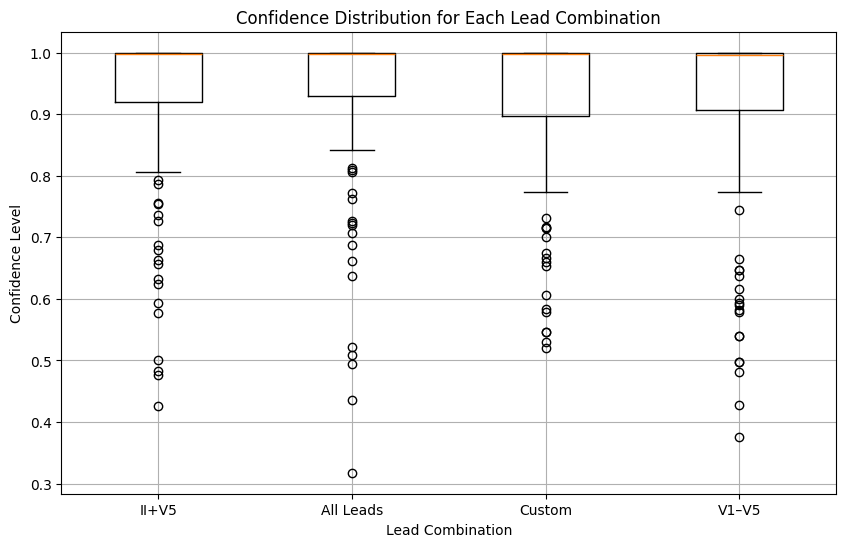

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load comparison file
file = "/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv"
df = pd.read_csv(file)

# Prepare data for boxplot
conf_cols = ["conf_ii_v5", "conf_all", "conf_custom", "conf_v1_v5"]
labels = ["II+V5", "All Leads", "Custom", "V1–V5"]

data = [df[c] for c in conf_cols]

plt.figure(figsize=(10,6))
plt.boxplot(data, labels=labels)
plt.title("Confidence Distribution for Each Lead Combination")
plt.ylabel("Confidence Level")
plt.xlabel("Lead Combination")
plt.grid(True)

plt.show()


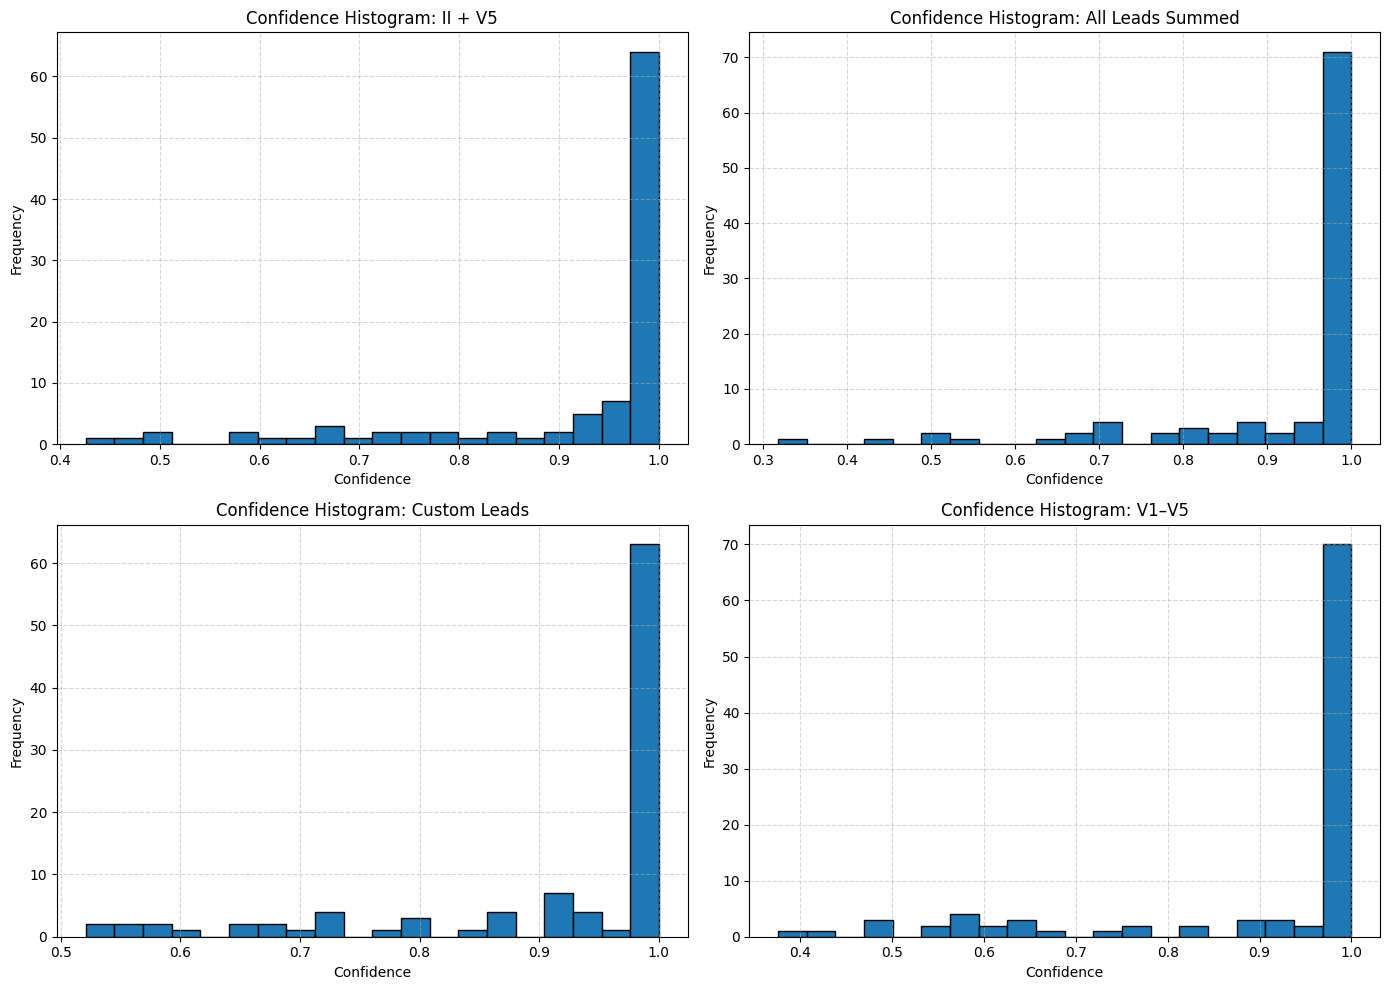

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your merged file
df = pd.read_csv('/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv')

# Which columns contain confidence values
conf_cols = ["conf_ii_v5", "conf_all", "conf_custom", "conf_v1_v5"]
titles = ["II + V5", "All Leads Summed", "Custom Leads", "V1–V5"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(conf_cols):
    plt.subplot(2, 2, i+1)
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f"Confidence Histogram: {titles[i]}")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv')
print(df.columns)


Index(['record', 'label_ii_v5', 'conf_ii_v5', 'label_all', 'conf_all',
       'label_custom', 'conf_custom', 'label_v1_v5', 'conf_v1_v5'],
      dtype='object')


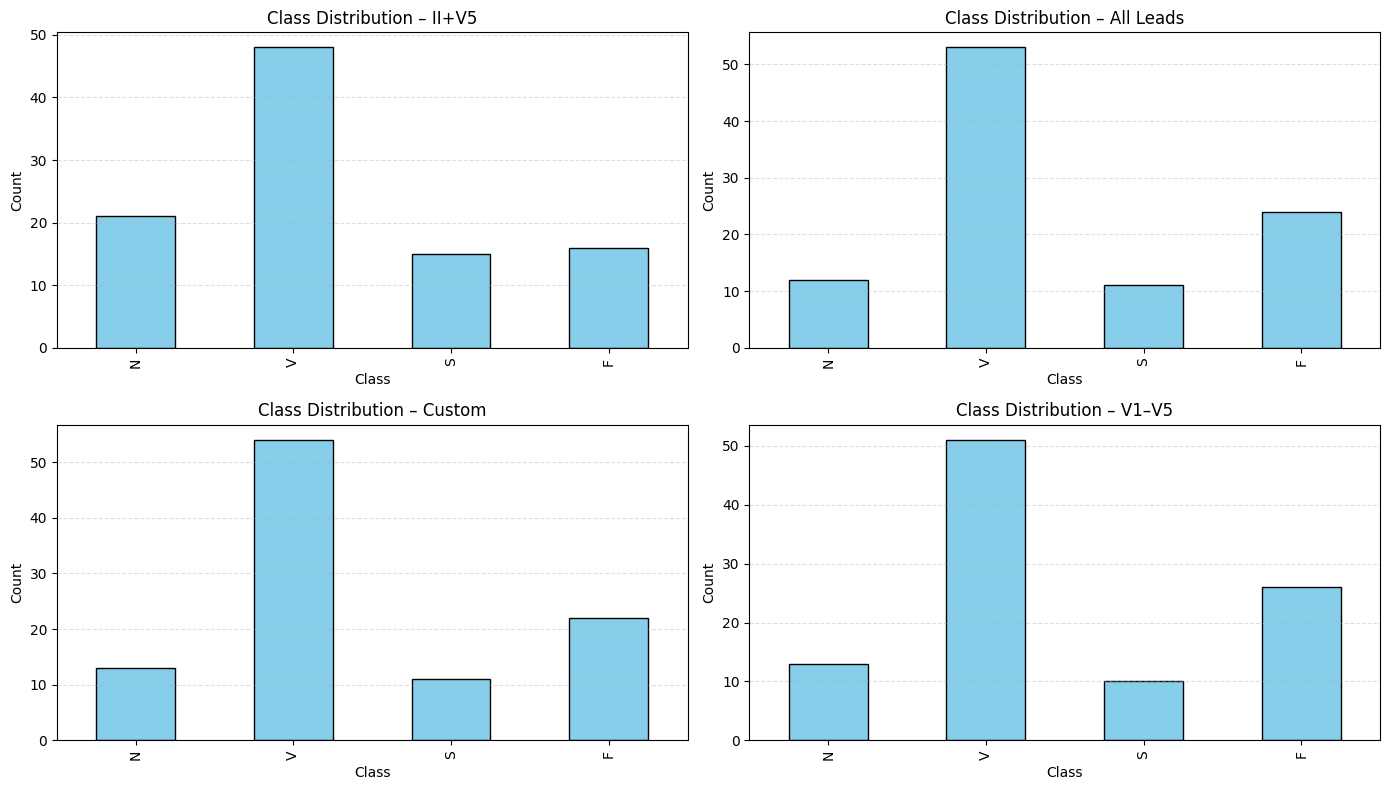


========== FIRST 10 DISAGREEMENTS ==========

                                               record label_ii_v5 label_all  \
0   /content/drive/MyDrive/mit_bih/ptb_xl_download...           S         S   
1   /content/drive/MyDrive/mit_bih/ptb_xl_download...           V         V   
2   /content/drive/MyDrive/mit_bih/ptb_xl_download...           N         F   
3   /content/drive/MyDrive/mit_bih/ptb_xl_download...           F         V   
5   /content/drive/MyDrive/mit_bih/ptb_xl_download...           F         V   
9   /content/drive/MyDrive/mit_bih/ptb_xl_download...           V         N   
10  /content/drive/MyDrive/mit_bih/ptb_xl_download...           S         V   
11  /content/drive/MyDrive/mit_bih/ptb_xl_download...           S         V   
12  /content/drive/MyDrive/mit_bih/ptb_xl_download...           S         V   
14  /content/drive/MyDrive/mit_bih/ptb_xl_download...           V         V   

   label_custom label_v1_v5  
0             S           V  
1             F        

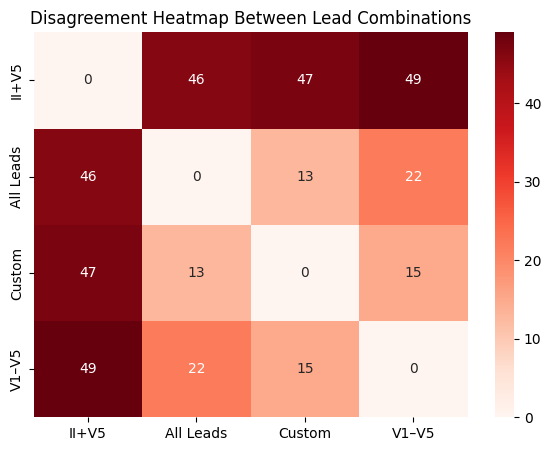

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load file
df = pd.read_csv('/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_4.csv')

# Use your actual label column names
lead_cols = ["label_ii_v5", "label_all", "label_custom", "label_v1_v5"]
lead_names = ["II+V5", "All Leads", "Custom", "V1–V5"]


# ======================================================
# 1. BAR CHART: Class Distribution per Combination
# ======================================================
plt.figure(figsize=(14, 8))

for i, col in enumerate(lead_cols):
    plt.subplot(2, 2, i+1)
    df[col].value_counts().reindex(["N", "V", "S", "F"]).plot(
        kind="bar", edgecolor="black", color="skyblue"
    )
    plt.title(f"Class Distribution – {lead_names[i]}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


# ======================================================
# 2. SHOW first 10 disagreements
# ======================================================
disagree_mask = (
    (df["label_ii_v5"] != df["label_all"]) |
    (df["label_ii_v5"] != df["label_custom"]) |
    (df["label_ii_v5"] != df["label_v1_v5"])
)

disagreements = df[disagree_mask][[
    "record", "label_ii_v5", "label_all", "label_custom", "label_v1_v5"
]]

print("\n========== FIRST 10 DISAGREEMENTS ==========\n")
print(disagreements.head(10))


# ======================================================
# 3. DISAGREEMENT COUNTS (pairwise)
# ======================================================
pairs = [
    ("label_ii_v5", "label_all"),
    ("label_ii_v5", "label_custom"),
    ("label_ii_v5", "label_v1_v5"),
    ("label_all", "label_custom"),
    ("label_all", "label_v1_v5"),
    ("label_custom", "label_v1_v5"),
]

print("\n========== DISAGREEMENT COUNTS ==========\n")
for a, b in pairs:
    diff = (df[a] != df[b]).sum()
    print(f"{a} vs {b}: {diff} disagreements")


# ======================================================
# 4. HEATMAP of Disagreement Counts
# ======================================================
matrix = pd.DataFrame(index=lead_names, columns=lead_names)

# Fill matrix with disagreement counts
for i, a in enumerate(lead_cols):
    for j, b in enumerate(lead_cols):
        if a == b:
            matrix.iloc[i, j] = 0
        else:
            matrix.iloc[i, j] = (df[a] != df[b]).sum()

matrix = matrix.astype(int)

plt.figure(figsize=(7, 5))
sns.heatmap(matrix, annot=True, cmap="Reds", fmt="d")
plt.title("Disagreement Heatmap Between Lead Combinations")
plt.show()


In [ ]:
import os

base = "/content/drive/MyDrive/mit_bih/ptb_xl_download"
for root, dirs, files in os.walk(base):
    if "ptbxl_database.csv" in files:
        print("FOUND:", os.path.join(root, "ptbxl_database.csv"))


FOUND: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/ptbxl_database.csv


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/ptbxl_database.csv"
df = pd.read_csv(path)

df.head(20)


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
5,6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
6,7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00007_lr,records500/00000/00007_hr
7,8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,...,True,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr
8,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr
9,10,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr


In [ ]:
'''data_dir = '/content/drive/MyDrive/mit_bih/'
MODEL_ORIGINAL_PATH = os.path.join(data_dir, 'my_summed_signal_model.keras')
MODEL_HEAVY_NOISY_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_noisy_model.keras')
MODEL_PURE_NOISE_PATH = os.path.join(data_dir, 'model_B_noisy.keras')
MODEL_MIXED_FT_PATH = os.path.join(data_dir, 'my_fine_tuned_v2_mixed_low_noise_model.keras')'''

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import os
import wfdb
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

# ============================
# CONFIG
# ============================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'
PTB_ROOT = os.path.join(DATA_DIR,
        'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500')

MODEL_PATH = os.path.join(DATA_DIR, 'my_fine_tuned_v2_mixed_low_noise_model.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

OUTPUT_CSV = "/content/drive/MyDrive/5050ptb.csv"

INPUT_LEN = 180  # model input requirement


# ============================
# PREPROCESSOR (Lead II + V5)
# ============================
def preprocess(record_path):
    rec = wfdb.rdrecord(record_path, pn_dir=None)
    sig = rec.p_signal

    if sig.shape[1] < 6:
        raise ValueError("Record does not contain enough leads (needs lead II & V5).")

    lead_II = sig[:, 1]
    lead_V5 = sig[:, 5]

    summed = lead_II + lead_V5

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed.reshape(-1, 1)).flatten()

    if len(scaled) < INPUT_LEN:
        raise ValueError("Record smaller than 180 samples.")

    segment = scaled[:INPUT_LEN]
    return np.expand_dims(segment, axis=(0, -1))  # (1,180,1)


# ============================
# LOAD MODEL
# ============================
print("Loading model...")
model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
print("Model loaded. Classes:", list(encoder.classes_))


# ============================
# GET RECORD LIST
# ============================
record_paths = []

for root, dirs, files in os.walk(PTB_ROOT):
    for f in files:
        if f.endswith(".dat"):
            full = os.path.join(root, f[:-4])  # remove .dat
            record_paths.append(full)

record_paths = sorted(record_paths)[:100]  # TAKE ONLY FIRST 100 RECORDS

print(f"\nTotal records used: {len(record_paths)}")


# ============================
# PREDICT LOOP
# ============================
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["record", "predicted_class", "confidence", "softmax"])

    for rec in record_paths:
        try:
            print("\nProcessing:", rec)

            X = preprocess(rec)
            probs = model.predict(X, verbose=0)[0]

            cls_idx = np.argmax(probs)
            label = encoder.classes_[cls_idx]
            confidence = float(probs[cls_idx])

            print(" →", label, " (confidence:", round(confidence, 4), ")")

            writer.writerow([
                rec,
                label,
                confidence,
                probs.tolist()
            ])

        except Exception as e:
            print(" ❌ Error:", e)
            writer.writerow([rec, "ERROR", "NA", str(e)])


print("\n\n===============================")
print("Prediction File Saved At:")
print(OUTPUT_CSV)
print("===============================")


Loading model...
Model loaded. Classes: ['F', 'N', 'S', 'V']

Total records used: 100

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → S  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → N  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → F  (confidence: 0.9953 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → F  (confidence: 0.4553 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → F  (confidence: 0.9999 )

Processing: /content/drive/MyDrive/mit_b

In [ ]:
import os
import wfdb
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

# ============================
# CONFIG
# ============================
DATA_DIR = '/content/drive/MyDrive/mit_bih/'
PTB_ROOT = os.path.join(DATA_DIR,
        'ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500')

MODEL_PATH = os.path.join(DATA_DIR, 'model_B_noisy.keras')
ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.joblib')

OUTPUT_CSV = "/content/drive/MyDrive/noisy_allptb.csv"

INPUT_LEN = 180  # model input requirement


# ============================
# PREPROCESSOR (Lead II + V5)
# ============================
def preprocess(record_path):
    rec = wfdb.rdrecord(record_path, pn_dir=None)
    sig = rec.p_signal

    if sig.shape[1] < 6:
        raise ValueError("Record does not contain enough leads (needs lead II & V5).")

    lead_II = sig[:, 1]
    lead_V5 = sig[:, 5]

    summed = lead_II + lead_V5

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summed.reshape(-1, 1)).flatten()

    if len(scaled) < INPUT_LEN:
        raise ValueError("Record smaller than 180 samples.")

    segment = scaled[:INPUT_LEN]
    return np.expand_dims(segment, axis=(0, -1))  # (1,180,1)


# ============================
# LOAD MODEL
# ============================
print("Loading model...")
model = load_model(MODEL_PATH)
encoder = joblib.load(ENCODER_PATH)
print("Model loaded. Classes:", list(encoder.classes_))


# ============================
# GET RECORD LIST
# ============================
record_paths = []

for root, dirs, files in os.walk(PTB_ROOT):
    for f in files:
        if f.endswith(".dat"):
            full = os.path.join(root, f[:-4])  # remove .dat
            record_paths.append(full)

record_paths = sorted(record_paths)[:100]  # TAKE ONLY FIRST 100 RECORDS

print(f"\nTotal records used: {len(record_paths)}")


# ============================
# PREDICT LOOP
# ============================
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["record", "predicted_class", "confidence", "softmax"])

    for rec in record_paths:
        try:
            print("\nProcessing:", rec)

            X = preprocess(rec)
            probs = model.predict(X, verbose=0)[0]

            cls_idx = np.argmax(probs)
            label = encoder.classes_[cls_idx]
            confidence = float(probs[cls_idx])

            print(" →", label, " (confidence:", round(confidence, 4), ")")

            writer.writerow([
                rec,
                label,
                confidence,
                probs.tolist()
            ])

        except Exception as e:
            print(" ❌ Error:", e)
            writer.writerow([rec, "ERROR", "NA", str(e)])


print("\n\n===============================")
print("Prediction File Saved At:")
print(OUTPUT_CSV)
print("===============================")


Loading model...
Model loaded. Classes: ['F', 'N', 'S', 'V']

Total records used: 100

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00001_hr
 → S  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00002_hr
 → V  (confidence: 0.7111 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00003_hr
 → N  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00004_hr
 → N  (confidence: 0.9996 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00005_hr
 → V  (confidence: 1.0 )

Processing: /content/drive/MyDrive/mit_bih/ptb_xl_download/physionet.org/files/ptb-xl/1.0.1/records500/00000/00006_hr
 → N  (confidence: 0.9526 )

Processing: /content/drive/MyDrive/mit_b

In [ ]:
import pandas as pd

# ======================================
# FILE PATHS
# ======================================
file_ii_v5050 = "/content/drive/MyDrive/5050ptb.csv"
file_ii_vnoisy="/content/drive/MyDrive/noisy_allptb.csv"

output_file = "/content/drive/MyDrive/ptb_xl_5050_noisy.csv"

# ======================================
# LOAD & FILTER REQUIRED COLUMNS
# ======================================
def load_and_clean(path, label_suffix):
    df = pd.read_csv(path)

    # Keep only the necessary columns
    keep_cols = [c for c in df.columns if c in ["record", "predicted_class", "confidence"]]
    df = df[keep_cols]

    # Rename for merging
    df = df.rename(columns={
        "predicted_class": f"label_{label_suffix}",
        "confidence": f"conf_{label_suffix}"
    })

    return df

df_ii_v5050 = load_and_clean(file_ii_v5050, "ii_v5_5050")
df_ii_vnoisy = load_and_clean(file_ii_vnoisy, "ii_v5_noisy")



# ======================================
# MERGE ALL FOUR SAFELY
# ======================================
df = df_ii_v5050.merge(df_ii_vnoisy, on="record", how="outer")


# ======================================
# SAVE FINAL COMPARISON
# ======================================
df.to_csv(output_file, index=False)

print("\n=====================================")
print("Final Comparison File Saved:")
print(output_file)
print("=====================================")



Final Comparison File Saved:
/content/drive/MyDrive/ptb_xl_5050_noisy.csv


In [ ]:
df["same_label"] = df["label_ii_v5_5050"] == df["label_ii_v5_noisy"]


In [ ]:
print(df["same_label"].value_counts())


same_label
False    61
True     39
Name: count, dtype: int64


In [ ]:
df_diff = df[df["same_label"] == False]
print(df_diff.head())


                                              record label_ii_v5_5050  \
3  /content/drive/MyDrive/mit_bih/ptb_xl_download...                F   
4  /content/drive/MyDrive/mit_bih/ptb_xl_download...                F   
5  /content/drive/MyDrive/mit_bih/ptb_xl_download...                F   
6  /content/drive/MyDrive/mit_bih/ptb_xl_download...                V   
7  /content/drive/MyDrive/mit_bih/ptb_xl_download...                F   

   conf_ii_v5_5050 label_ii_v5_noisy  conf_ii_v5_noisy  same_label  
3         0.995284                 N          0.999591       False  
4         0.455251                 V          0.999985       False  
5         0.999876                 N          0.952558       False  
6         0.994738                 N          0.978603       False  
7         0.999698                 V          0.413774       False  


In [ ]:
df["conf_diff"] = df["conf_ii_v5_5050"] - df["conf_ii_v5_noisy"]


In [ ]:
df_big_conf_diff = df.sort_values("conf_diff", key=abs, ascending=False)
df_big_conf_diff.head()


,record,label_ii_v5_5050,conf_ii_v5_5050,label_ii_v5_noisy,conf_ii_v5_noisy,same_label,conf_diff
7,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.999698,V,0.413774,False,0.585925
4,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.455251,V,0.999985,False,-0.544734
34,/content/drive/MyDrive/mit_bih/ptb_xl_download...,S,0.525739,N,0.999995,False,-0.474257
91,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.531541,N,0.991156,False,-0.459614
95,/content/drive/MyDrive/mit_bih/ptb_xl_download...,F,0.987734,V,0.530761,False,0.456972


In [ ]:
pd.crosstab(df["label_ii_v5_5050"], df["label_ii_v5_noisy"])


label_ii_v5_noisy,N,S,V
label_ii_v5_5050,,,
F,13,1,5
N,18,1,1
S,9,4,1
V,30,0,17


In [ ]:
summary = {
    "total_records": len(df),
    "same_predictions": df["same_label"].sum(),
    "different_predictions": (~df["same_label"]).sum(),
    "agreement_rate": df["same_label"].mean()
}

print(summary)


{'total_records': 100, 'same_predictions': np.int64(39), 'different_predictions': np.int64(61), 'agreement_rate': np.float64(0.39)}


In [ ]:
import pandas as pd

# ======================================
# FILE PATHS (ALL 6 MODELS)
# ======================================
file_ii_v5_5050 = "/content/drive/MyDrive/5050ptb.csv"
file_ii_v5_noisy = "/content/drive/MyDrive/noisy_allptb.csv"

file_ii_v5 = "/content/drive/MyDrive/ptb_xl_predictions_100.csv"
file_all = "/content/drive/MyDrive/ptb_xl_predictions_100_all_leads.csv"
file_custom = "/content/drive/MyDrive/ptb_xl_predictions_100_leads_II_aVR_V1toV5.csv"
file_v1_v5 = "/content/drive/MyDrive/ptb_xl_predictions_100_leadsV1toV5.csv"

output_file = "/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_6.csv"

# ======================================
# LOAD FUNCTION
# ======================================
def load_and_clean(path, label_suffix):
    df = pd.read_csv(path)
    keep_cols = [c for c in df.columns if c in ["record", "predicted_class", "confidence"]]
    df = df[keep_cols]

    df = df.rename(columns={
        "predicted_class": f"label_{label_suffix}",
        "confidence": f"conf_{label_suffix}"
    })
    return df

# ======================================
# LOAD ALL 6 FILES
# ======================================
df_ii_v5_5050 = load_and_clean(file_ii_v5_5050, "ii_v5_5050")
df_ii_v5_noisy = load_and_clean(file_ii_v5_noisy, "ii_v5_noisy")

df_ii_v5 = load_and_clean(file_ii_v5, "ii_v5")
df_all = load_and_clean(file_all, "all")
df_custom = load_and_clean(file_custom, "custom")
df_v1_v5 = load_and_clean(file_v1_v5, "v1_v5")

# ======================================
# MERGE EVERYTHING ON "record"
# ======================================
df = df_ii_v5_5050.merge(df_ii_v5_noisy, on="record", how="outer")
df = df.merge(df_ii_v5, on="record", how="outer")
df = df.merge(df_all, on="record", how="outer")
df = df.merge(df_custom, on="record", how="outer")
df = df.merge(df_v1_v5, on="record", how="outer")

# ======================================
# SAVE MASTER COMPARISON FILE
# ======================================
df.to_csv(output_file, index=False)

print("\n=====================================")
print("Master Comparison File Saved:")
print(output_file)
print("=====================================")



Master Comparison File Saved:
/content/drive/MyDrive/ptb_xl_predictions_comparison_ALL_6.csv


In [ ]:
label_cols = [c for c in df.columns if c.startswith("label_")]
df["num_unique_predictions"] = df[label_cols].nunique(axis=1)


In [ ]:
df_disagree = df[df["num_unique_predictions"] > 1]


In [ ]:
(df["label_ii_v5"] == df["label_all"]).mean()


np.float64(0.54)

In [ ]:
pd.crosstab(df["label_custom"], df["label_v1_v5"])


label_v1_v5,F,N,S,V
label_custom,,,,
F,21,0,0,1
N,0,10,1,2
S,3,0,7,1
V,2,3,2,47
